<a href="https://colab.research.google.com/github/ElmiraOn/P4-CRISTAL-Replication/blob/EECS6448_CRISTAL_suggestions/CRISTAL_Enhancement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imports

In [ ]:
!pip install translators

In [ ]:
!pip install langdetect

In [ ]:
!pip install emoji

In [ ]:
!pip install contractions

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download() ## select `all-nltk` and then download on jupyter note book

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> all-nltk


       | 
       | Downloading package abc to /root/nltk_data...
       |   Unzipping corpora/abc.zip.
       | Downloading package alpino to /root/nltk_data...
       |   Unzipping corpora/alpino.zip.
       | Downloading package averaged_perceptron_tagger to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger.zip.
       | Downloading package averaged_perceptron_tagger_ru to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger_ru.zip.
       | Downloading package basque_grammars to /root/nltk_data...
       |   Unzipping grammars/basque_grammars.zip.
       | Downloading package bcp47 to /root/nltk_data...
       | Downloading package biocreative_ppi to /root/nltk_data...
       |   Unzipping corpora/biocreative_ppi.zip.
       | Downloading package bllip_wsj_no_aux to /root/nltk_data...
       |   Unzipping models/bllip_wsj_no_aux.zip.
       | Downloading package book_grammars to /root/nltk_data...
       |   Un

In [ ]:
pip install num2words

In [ ]:
pip install -U sentence-transformers

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path
from imblearn.under_sampling import RandomUnderSampler
import re
import string
import pickle
from emoji import EMOJI_DATA
import contractions
import nltk
from num2words import num2words
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score
from time import time
from sklearn.model_selection import GridSearchCV # used for tuning algorithms and hyperparameters
from sklearn.svm import SVC
from ast import literal_eval
from sentence_transformers import SentenceTransformer
from pathlib import Path
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from nltk.stem.porter import *
import torch
import numpy as np
from transformers import BertTokenizer, BertModel

# Helper Functions

In [ ]:
## replacing emojis with words
# 'Emoji_Dict.p'- download link https://drive.google.com/open?id=1G1vIkkbqPBYPKHcQ8qy0G2zkoab2Qv4v
with open('/content/drive/MyDrive/EECS6448/Emoji_Dict.p', 'rb') as fp:
    Emoji_Dict = pickle.load(fp)
Emoji_Dict = {v: k for k, v in Emoji_Dict.items()}

def convert_emojis_to_word(text):
    for emot in Emoji_Dict:
        text = re.sub(r'('+emot+')', "_".join(Emoji_Dict[emot].replace(",","").replace(":","").split()), text)
    return text

#example:
#convert_emojis_to_word("I like to eat 🍕") #--> I like to eat pizza

## convert emoticemoticons
# 'Emoticon_Dict.p'- download link https://drive.google.com/open?id=1HDpafp97gCl9xZTQWMgP2kKK_NuhENlE
with open('/content/drive/MyDrive/EECS6448/Emoticon_Dict.p', 'rb') as fp:
    Emoticon_Dict = pickle.load(fp)

def convert_emoticons(text):
    for emot in Emoticon_Dict:
        text = re.sub(u'('+emot+')', "_".join(Emoticon_Dict[emot].replace(",","").split()), text)
    return text

In [ ]:
# this function use to seperate number if they are attached to a word
def sep_num_words_func(text):
    return re.sub(r"([0-9]+(\.[0-9]+)?)",r" \1 ", text).strip()
# this function convert number to words
def num_to_words(text):
    text_sep = sep_num_words_func(text)
    after_spliting = text_sep.split()

    for index in range(len(after_spliting)):
        if after_spliting[index].isdigit():
            after_spliting[index] = num2words(after_spliting[index])
    numbers_to_words = ' '.join(after_spliting)
    return numbers_to_words

In [ ]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

# A. Benchmarking AR miner

## Replicaiton of P4-CRISTAL AR Miner

In [ ]:
from __future__ import annotations

import json
import warnings

import pandas as pd
import nltk

from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer


from ast import literal_eval
from pathlib import Path

import re
from nltk.corpus import stopwords

# warnings.filterwarnings('ignore')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
cols = ['app', 'platform', 'pkg', 'id', 'lang', 'blank', 'type', 'date', 'user', 'title', 'User Review']
data = pd.read_excel(Path('/content/drive/MyDrive/EECS6448/Informative_Training_Set.xlsx'), names=cols, header=None).drop('blank', axis=1)
data['informative'] = data['type'].apply(lambda x: x <= 2)
data['User Review'] = data['User Review'].apply(lambda x: str(x))

data.head()

,app,platform,pkg,id,lang,type,date,user,title,User Review,informative
0,Instagram,Google Play,com.instagram.android,Z3A6QU9xcFRPRUNyR05RcVZVV2t2ZzR0eXNpNTB2QXkwdz...,English,2,2016-08-05,Angie Martinez,New instagram,I hate the new instagram I don't see why gotta...,True
1,Instagram,Google Play,com.instagram.android,Z3A6QU9xcFRPRzhuenVHSUpsNGU3YVI1U3h5RVFETjJ2Y0...,English,5,2016-08-05,Emad Jadalla,So nice,I love it . So easy . Fabulous â™¥,False
2,Instagram,Google Play,com.instagram.android,Z3A6QU9xcFRPR2c3UmI4VWFVWGhCMGI1VEowczQ3cGZtRF...,English,5,2016-08-05,Halie Godesky,Love it,Its great,False
3,Instagram,Google Play,com.instagram.android,Z3A6QU9xcFRPRTltSjhyd09zYk5vaVNFMldURHQwUzNxbU...,English,1,2016-08-05,Tamera Campbell,Update,"Please get rid of ""stories"" the video quality ...",True
4,Instagram,Google Play,com.instagram.android,Z3A6QU9xcFRPRmcwYjA3U1RBZl80MFV4WDFjX1JGeE1hWn...,English,4,2016-08-05,adam haris,nice app,good,False


In [ ]:
stop_words = {w.lower() for w in stopwords.words('english')}

# Data Cleaning
def clean_text(text: str):
    # remove everything except alphabets
    text = re.sub("[^a-zA-Z]", " ", text.lower())
    # remove stop words
    text = ' '.join(w for w in text.split() if not w in stop_words)
    return text


data['soup'] = data['User Review'].apply(clean_text)
data.sample(3)

,app,platform,pkg,id,lang,type,date,user,title,User Review,informative,soup
3142,Tumblr,Google Play,com.tumblr,Z3A6QU9xcFRPRVpsVUtQaXFJbnUtdVlzYVhOVnNjbFFOM2...,English,2,2016-08-04,Camilo Diaz Pino,Glitchy,Frequently crashes,True,frequently crashes
5305,VLC for Android,Google Play,org.videolan.vlc,Z3A6QU9xcFRPRlpBd3lvTnRxOEE0VFVnM1NiY1BnREVRZV...,English,5,2016-08-05,sushanta mondal,Nice,Good,False,good
3460,Tumblr,Google Play,com.tumblr,Z3A6QU9xcFRPRmNqbWstdzJQdkd3aV9zMF9xZDB5RXVzQl...,English,3,2016-08-02,jesse J garcia Sr,Damn!!,This app crashes alot when scrolling thru a cl...,False,app crashes alot scrolling thru cluster gifs


In [ ]:
def resample(data):
    """
    Resample data so that it has similar numbers of 0 and 1s
    """
    d1 = data[data.informative == True]
    d0 = data[data.informative == False]
    num_1s = len(d1)
    num_0s = len(d0)
    final = min(num_1s, num_0s)

    return pd.concat([d1.sample(final), d0.sample(final)], ignore_index=True)


print(f'The data has {sum(data["informative"]) / len(data) * 100:.1f}% informative reviews')
data = resample(data)
print(f'The data has {sum(data["informative"]) / len(data) * 100:.1f}% informative reviews after resample')

The data has 17.8% informative reviews
The data has 50.0% informative reviews after resample


In [ ]:
stem_process = PorterStemmer()

def tokenize_and_stem(text):
    # tokenization to ensure that punctuation is caught as its own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []

    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    lem = [stem_process.stem(t) for t in filtered_tokens]
    return lem

# Defining a TF-IDF Vectorizer
tfidf_vec = TfidfVectorizer(ngram_range=(1, 2), tokenizer=tokenize_and_stem, max_features=10000, use_idf=True)

# mb = MultiLabelBinarizer()
# mb.fit(data['Class'])

# y = mb.transform(data['Class'])

y = data['informative']

# Basic validation: splitting the data 80-20 train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['soup'], y, test_size=0.2, random_state=55)

# Tf-Idf transformation
xtrain_tfidf = tfidf_vec.fit_transform(X_train)
xtest_tfidf = tfidf_vec.transform(X_test)
xtrain_tfidf.shape


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(2280, 10000)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier

multinomial_clf = MultinomialNB(alpha=0.1)
oneVsRest_rf = OneVsRestClassifier(multinomial_clf)

oneVsRest_rf.fit(xtrain_tfidf, y_train)


OneVsRestClassifier(estimator=MultinomialNB(alpha=0.1))

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

y_pred1 = oneVsRest_rf.predict(xtest_tfidf)

# Performance metrics
precision, recall, f1score, support = precision_recall_fscore_support(y_test, y_pred1, average='binary')
print(f'Precision: {precision*100:.1f}%')
print(f'Recall   : {recall*100:.1f}%')
print(f'F1-score : {f1score*100:.1f}%')

Precision: 81.8%
Recall   : 75.2%
F1-score : 78.4%


## Balancing Data

In [ ]:
def read_type_data():
    """
    Read data from the paper "Bug Report, Feature Request, or Simply Praise?" (Maalej & Nabil 2016)
    """
    cols = ['app', 'platform', 'pkg', 'id', 'lang', 'blank', 'type', 'date', 'user', 'title', 'User Review']
    data = pd.read_excel(Path('/content/drive/MyDrive/EECS6448/Informative_Training_Set.xlsx'), names=cols, header=None).drop('blank', axis=1)
    data['informative'] = data['type'].apply(lambda x: x <= 2)
    # data['Class'] = data['informative'].apply(lambda x: ['Informative'] if x else ['Non-informative'])
    data['User Review'] = data['User Review'].apply(lambda x: str(x))
    return data

df= read_type_data()


### Data Exploration

In [ ]:
df.head()

,app,platform,pkg,id,lang,type,date,user,title,User Review,informative
0,Instagram,Google Play,com.instagram.android,Z3A6QU9xcFRPRUNyR05RcVZVV2t2ZzR0eXNpNTB2QXkwdz...,English,2,2016-08-05,Angie Martinez,New instagram,I hate the new instagram I don't see why gotta...,True
1,Instagram,Google Play,com.instagram.android,Z3A6QU9xcFRPRzhuenVHSUpsNGU3YVI1U3h5RVFETjJ2Y0...,English,5,2016-08-05,Emad Jadalla,So nice,I love it . So easy . Fabulous â™¥,False
2,Instagram,Google Play,com.instagram.android,Z3A6QU9xcFRPR2c3UmI4VWFVWGhCMGI1VEowczQ3cGZtRF...,English,5,2016-08-05,Halie Godesky,Love it,Its great,False
3,Instagram,Google Play,com.instagram.android,Z3A6QU9xcFRPRTltSjhyd09zYk5vaVNFMldURHQwUzNxbU...,English,1,2016-08-05,Tamera Campbell,Update,"Please get rid of ""stories"" the video quality ...",True
4,Instagram,Google Play,com.instagram.android,Z3A6QU9xcFRPRmcwYjA3U1RBZl80MFV4WDFjX1JGeE1hWn...,English,4,2016-08-05,adam haris,nice app,good,False


In [ ]:
len(df)

8000

#### Removing NaN user review

In [ ]:
len(df[df["User Review"]=="nan" ])

34

<Axes: xlabel='informative', ylabel='count'>

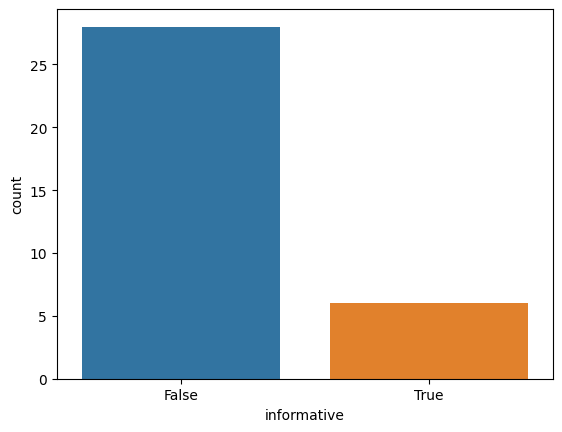

In [ ]:
d1 = df[df["User Review"]=="nan" ]
sns.countplot(x='informative', data=d1)

In [ ]:
df = df[df["User Review"]!="nan"]

In [ ]:
len(df)

7966

#### Balancing dataset by Random downsampling

<Axes: xlabel='informative', ylabel='count'>

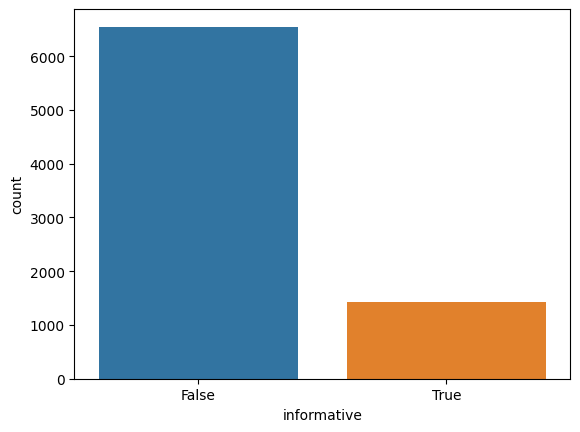

In [ ]:
sns.countplot(x='informative', data=df)

In [ ]:
num_false = len(df[df["informative"] == False])
num_true = len(df[df["informative"] == True])
print("There are "  +str(num_true) + " informative reviews. ")
print("There are "  +str(num_false) + " non-informative reviews. ")

There are 1419 informative reviews. 
There are 6547 non-informative reviews. 


We randomly downsample the "False" class using RandomUnderSampler method

In [ ]:
X=df.drop('informative',axis=1)
y=df['informative']
rus = RandomUnderSampler(sampling_strategy='not minority', random_state = 0)
X_res, y_res = rus.fit_resample(X, y)



In [ ]:
df = X_res
df["informative"] = y_res

<Axes: xlabel='informative', ylabel='count'>

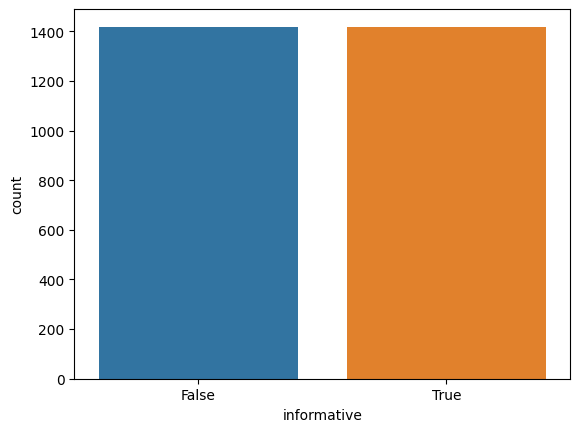

In [ ]:
sns.countplot(x='informative', data=df)

In [ ]:
num_false = len(df[df["informative"] == False])
num_true = len(df[df["informative"] == True])
print("There are "  +str(num_true) + " informative reviews. ")
print("There are "  +str(num_false) + " non-informative reviews. ")

There are 1419 informative reviews. 
There are 1419 non-informative reviews. 


In [ ]:
df.to_csv("/content/drive/MyDrive/EECS6448/Informative_balanced.csv", index = False)

## Method using TF-IDF vectorization

### read data

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/EECS6448/Informative_balanced.csv")

In [ ]:
df.head()

,app,platform,pkg,id,lang,type,date,user,title,User Review,informative
0,Snapchat,Google Play,com.snapchat.android,Z3A6QU9xcFRPRUUtNDFoRGNNR0tvcW9mOVNKd3EyN1VhVW...,English,5,2016-08-04,only boys aloud,Amazing,Wow all that music,False
1,VLC for Android,Google Play,org.videolan.vlc,Z3A6QU9xcFRPSFFuZUpFWmFwWGdoZ1BJT3RQdXY2dm0tZV...,English,5,2016-08-03,Ã¡J!tH ThOmÃ s,NaN,Good app I love itt,False
2,Spotify Music,Google Play,com.spotify.music,Z3A6QU9xcFRPRkg4eDVyVGgxOXdxektHREJWV004T0hkZG...,English,5,2016-08-05,Harold Junn Salvacion,nice,now i can listen my favorite song.. tnx spotify..,False
3,LinkedIn,Google Play,com.linkedin.android,Z3A6QU9xcFRPRU1OV1dTQnppUW5nOVV0TzFBMXBZbl9vWk...,English,3,2016-07-29,Stephen Morning,Invitation to communicate about what matters b...,R\u0026amp;D,False
4,Spotify Music,Google Play,com.spotify.music,Z3A6QU9xcFRPRnB1MGZwbnhfXzdWRXRlbnkyZHBZR1dTU3...,English,5,2016-08-05,gabriel yamasaki,Great music app,Has just about everything I need for my ears,False


### cleaning

In [ ]:
def clean_text(text):
  try:
    text = text.lower()
    punc =  string.punctuation
    text = "".join([char for char in text if char not in string.punctuation])
    text =  " ".join(text.split())
    text = convert_emojis_to_word(text)
    text = convert_emoticons(text)
    text = num_to_words(text)
    return text
  except:
    return ""


In [ ]:
df['User Review'] = df['User Review'].apply(clean_text)
df.head()

,app,platform,pkg,id,lang,type,date,user,title,User Review,informative
0,Snapchat,Google Play,com.snapchat.android,Z3A6QU9xcFRPRUUtNDFoRGNNR0tvcW9mOVNKd3EyN1VhVW...,English,5,2016-08-04,only boys aloud,Amazing,wow all that music,False
1,VLC for Android,Google Play,org.videolan.vlc,Z3A6QU9xcFRPSFFuZUpFWmFwWGdoZ1BJT3RQdXY2dm0tZV...,English,5,2016-08-03,Ã¡J!tH ThOmÃ s,NaN,good app i love itt,False
2,Spotify Music,Google Play,com.spotify.music,Z3A6QU9xcFRPRkg4eDVyVGgxOXdxektHREJWV004T0hkZG...,English,5,2016-08-05,Harold Junn Salvacion,nice,now i can listen my favorite song tnx spotify,False
3,LinkedIn,Google Play,com.linkedin.android,Z3A6QU9xcFRPRU1OV1dTQnppUW5nOVV0TzFBMXBZbl9vWk...,English,3,2016-07-29,Stephen Morning,Invitation to communicate about what matters b...,ru twenty-six ampd,False
4,Spotify Music,Google Play,com.spotify.music,Z3A6QU9xcFRPRnB1MGZwbnhfXzdWRXRlbnkyZHBZR1dTU3...,English,5,2016-08-05,gabriel yamasaki,Great music app,has just about everything i need for my ears,False


In [ ]:
df.to_csv("/content/drive/MyDrive/EECS6448/Informative_TFIDF_cleaned.csv", index = False)

### Tokenizing/ lemmatizing/ stopword removal

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/EECS6448/Informative_TFIDF_cleaned.csv")
df.head()

,app,platform,pkg,id,lang,type,date,user,title,User Review,informative
0,Snapchat,Google Play,com.snapchat.android,Z3A6QU9xcFRPRUUtNDFoRGNNR0tvcW9mOVNKd3EyN1VhVW...,English,5,2016-08-04,only boys aloud,Amazing,wow all that music,False
1,VLC for Android,Google Play,org.videolan.vlc,Z3A6QU9xcFRPSFFuZUpFWmFwWGdoZ1BJT3RQdXY2dm0tZV...,English,5,2016-08-03,Ã¡J!tH ThOmÃ s,NaN,good app i love itt,False
2,Spotify Music,Google Play,com.spotify.music,Z3A6QU9xcFRPRkg4eDVyVGgxOXdxektHREJWV004T0hkZG...,English,5,2016-08-05,Harold Junn Salvacion,nice,now i can listen my favorite song tnx spotify,False
3,LinkedIn,Google Play,com.linkedin.android,Z3A6QU9xcFRPRU1OV1dTQnppUW5nOVV0TzFBMXBZbl9vWk...,English,3,2016-07-29,Stephen Morning,Invitation to communicate about what matters b...,ru twenty-six ampd,False
4,Spotify Music,Google Play,com.spotify.music,Z3A6QU9xcFRPRnB1MGZwbnhfXzdWRXRlbnkyZHBZR1dTU3...,English,5,2016-08-05,gabriel yamasaki,Great music app,has just about everything i need for my ears,False


In [ ]:
d1 = df[df["User Review"]=="nan" ]
len(d1)
# sns.countplot(x='informative', data=d1)

0

In [ ]:
def tokenize(text):
  try:
    words = word_tokenize(text)
    return words
  except: return ""

In [ ]:
def remove_stop_words(text):
  text = [word for word in text if word not in stopwords.words('english')]
  return text


In [ ]:
df["User_Review_processed"] = ""

for i in range(len(df.index)):
  text = df["User Review"][i]
  words = tokenize(text)
  df["User_Review_processed"][i] = words
df.head()

<ipython-input-27-01d5b9c41bf0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["User_Review_processed"][i] = words


,app,platform,pkg,id,lang,type,date,user,title,User Review,informative,User_Review_processed
0,Snapchat,Google Play,com.snapchat.android,Z3A6QU9xcFRPRUUtNDFoRGNNR0tvcW9mOVNKd3EyN1VhVW...,English,5,2016-08-04,only boys aloud,Amazing,wow all that music,False,"[wow, all, that, music]"
1,VLC for Android,Google Play,org.videolan.vlc,Z3A6QU9xcFRPSFFuZUpFWmFwWGdoZ1BJT3RQdXY2dm0tZV...,English,5,2016-08-03,Ã¡J!tH ThOmÃ s,NaN,good app i love itt,False,"[good, app, i, love, itt]"
2,Spotify Music,Google Play,com.spotify.music,Z3A6QU9xcFRPRkg4eDVyVGgxOXdxektHREJWV004T0hkZG...,English,5,2016-08-05,Harold Junn Salvacion,nice,now i can listen my favorite song tnx spotify,False,"[now, i, can, listen, my, favorite, song, tnx,..."
3,LinkedIn,Google Play,com.linkedin.android,Z3A6QU9xcFRPRU1OV1dTQnppUW5nOVV0TzFBMXBZbl9vWk...,English,3,2016-07-29,Stephen Morning,Invitation to communicate about what matters b...,ru twenty-six ampd,False,"[ru, twenty-six, ampd]"
4,Spotify Music,Google Play,com.spotify.music,Z3A6QU9xcFRPRnB1MGZwbnhfXzdWRXRlbnkyZHBZR1dTU3...,English,5,2016-08-05,gabriel yamasaki,Great music app,has just about everything i need for my ears,False,"[has, just, about, everything, i, need, for, m..."


In [ ]:
df = df[df["User_Review_processed"]!=""]


In [ ]:
df["User_Review_processed"] = df["User_Review_processed"].apply(remove_stop_words)
df.head()

,app,platform,pkg,id,lang,type,date,user,title,User Review,informative,User_Review_processed
0,Snapchat,Google Play,com.snapchat.android,Z3A6QU9xcFRPRUUtNDFoRGNNR0tvcW9mOVNKd3EyN1VhVW...,English,5,2016-08-04,only boys aloud,Amazing,wow all that music,False,"[wow, music]"
1,VLC for Android,Google Play,org.videolan.vlc,Z3A6QU9xcFRPSFFuZUpFWmFwWGdoZ1BJT3RQdXY2dm0tZV...,English,5,2016-08-03,Ã¡J!tH ThOmÃ s,NaN,good app i love itt,False,"[good, app, love, itt]"
2,Spotify Music,Google Play,com.spotify.music,Z3A6QU9xcFRPRkg4eDVyVGgxOXdxektHREJWV004T0hkZG...,English,5,2016-08-05,Harold Junn Salvacion,nice,now i can listen my favorite song tnx spotify,False,"[listen, favorite, song, tnx, spotify]"
3,LinkedIn,Google Play,com.linkedin.android,Z3A6QU9xcFRPRU1OV1dTQnppUW5nOVV0TzFBMXBZbl9vWk...,English,3,2016-07-29,Stephen Morning,Invitation to communicate about what matters b...,ru twenty-six ampd,False,"[ru, twenty-six, ampd]"
4,Spotify Music,Google Play,com.spotify.music,Z3A6QU9xcFRPRnB1MGZwbnhfXzdWRXRlbnkyZHBZR1dTU3...,English,5,2016-08-05,gabriel yamasaki,Great music app,has just about everything i need for my ears,False,"[everything, need, ears]"


In [ ]:
def lemmitize(words):
  lemmatizer = WordNetLemmatizer()
  lem = [lemmatizer.lemmatize(word) for word in words]
  return lem

In [ ]:
df["User_Review_processed"] = df["User_Review_processed"].apply(lemmitize)
df.head()

,app,platform,pkg,id,lang,type,date,user,title,User Review,informative,User_Review_processed
0,Snapchat,Google Play,com.snapchat.android,Z3A6QU9xcFRPRUUtNDFoRGNNR0tvcW9mOVNKd3EyN1VhVW...,English,5,2016-08-04,only boys aloud,Amazing,wow all that music,False,"[wow, music]"
1,VLC for Android,Google Play,org.videolan.vlc,Z3A6QU9xcFRPSFFuZUpFWmFwWGdoZ1BJT3RQdXY2dm0tZV...,English,5,2016-08-03,Ã¡J!tH ThOmÃ s,NaN,good app i love itt,False,"[good, app, love, itt]"
2,Spotify Music,Google Play,com.spotify.music,Z3A6QU9xcFRPRkg4eDVyVGgxOXdxektHREJWV004T0hkZG...,English,5,2016-08-05,Harold Junn Salvacion,nice,now i can listen my favorite song tnx spotify,False,"[listen, favorite, song, tnx, spotify]"
3,LinkedIn,Google Play,com.linkedin.android,Z3A6QU9xcFRPRU1OV1dTQnppUW5nOVV0TzFBMXBZbl9vWk...,English,3,2016-07-29,Stephen Morning,Invitation to communicate about what matters b...,ru twenty-six ampd,False,"[ru, twenty-six, ampd]"
4,Spotify Music,Google Play,com.spotify.music,Z3A6QU9xcFRPRnB1MGZwbnhfXzdWRXRlbnkyZHBZR1dTU3...,English,5,2016-08-05,gabriel yamasaki,Great music app,has just about everything i need for my ears,False,"[everything, need, ear]"


In [ ]:
df.to_csv("/content/drive/MyDrive/EECS6448/Informative_TFIDF_processed.csv", index = False)


### Divide data

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/EECS6448/Informative_TFIDF_processed.csv")
df.head()

,app,platform,pkg,id,lang,type,date,user,title,User Review,informative,User_Review_processed
0,Snapchat,Google Play,com.snapchat.android,Z3A6QU9xcFRPRUUtNDFoRGNNR0tvcW9mOVNKd3EyN1VhVW...,English,5,2016-08-04,only boys aloud,Amazing,wow all that music,False,"['wow', 'music']"
1,VLC for Android,Google Play,org.videolan.vlc,Z3A6QU9xcFRPSFFuZUpFWmFwWGdoZ1BJT3RQdXY2dm0tZV...,English,5,2016-08-03,Ã¡J!tH ThOmÃ s,NaN,good app i love itt,False,"['good', 'app', 'love', 'itt']"
2,Spotify Music,Google Play,com.spotify.music,Z3A6QU9xcFRPRkg4eDVyVGgxOXdxektHREJWV004T0hkZG...,English,5,2016-08-05,Harold Junn Salvacion,nice,now i can listen my favorite song tnx spotify,False,"['listen', 'favorite', 'song', 'tnx', 'spotify']"
3,LinkedIn,Google Play,com.linkedin.android,Z3A6QU9xcFRPRU1OV1dTQnppUW5nOVV0TzFBMXBZbl9vWk...,English,3,2016-07-29,Stephen Morning,Invitation to communicate about what matters b...,ru twenty-six ampd,False,"['ru', 'twenty-six', 'ampd']"
4,Spotify Music,Google Play,com.spotify.music,Z3A6QU9xcFRPRnB1MGZwbnhfXzdWRXRlbnkyZHBZR1dTU3...,English,5,2016-08-05,gabriel yamasaki,Great music app,has just about everything i need for my ears,False,"['everything', 'need', 'ear']"


In [ ]:
len(df)

2831

In [ ]:
# keeping 20% to validate the models in the last step
y = df['informative']
X = df["User_Review_processed"]

X_train_all, X_validate, y_train_all, y_validate_tfidf = train_test_split(X, y, test_size=0.2, random_state=0)
print("There are " + str(len(X)) + " datapoint: ")
print("used for trainig with 10 fold cross validation: " + str(len(X_train_all)))
print("used for validation: " + str(len(X_validate)))

There are 2831 datapoint: 
used for trainig with 10 fold cross validation: 2264
used for validation: 567


In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000, use_idf=True) # same vectorizer as in P4-CRISTAL

In [ ]:
xtrain_tfidf = vectorizer.fit_transform(X_train_all)
X_validate_tfidf = vectorizer.transform(X_validate)
X_validate_tfidf.shape

(567, 10000)

In [ ]:
xtrain_tfidf.shape

(2264, 10000)

In [ ]:
# vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000, use_idf=True) # same vectorizer as in P4-CRISTAL

X_train, X_test, y_train, y_test = train_test_split(xtrain_tfidf, y_train_all, test_size=0.2, random_state=0)
X_train.shape
# X_test.shape

(1811, 10000)

In [ ]:
xtest_tfidf.shape

(453, 10000)

### TF-IDF + SVM

In [ ]:
svc = SVC()
parameters = { # used to search for the hyperparameters
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10]
}

cv = GridSearchCV(svc, parameters, cv=10) # cv = 5 --> 5 fold validation
cv.fit(X_train, y_train)

print_results(cv)

BEST PARAMS: {'C': 1, 'kernel': 'linear'}

0.675 (+/-0.055) for {'C': 0.1, 'kernel': 'linear'}
0.57 (+/-0.039) for {'C': 0.1, 'kernel': 'rbf'}
0.796 (+/-0.055) for {'C': 1, 'kernel': 'linear'}
0.78 (+/-0.057) for {'C': 1, 'kernel': 'rbf'}
0.777 (+/-0.068) for {'C': 10, 'kernel': 'linear'}
0.782 (+/-0.056) for {'C': 10, 'kernel': 'rbf'}


In [ ]:
cv.best_estimator_

SVC(C=1, kernel='linear')

In [ ]:
svm_classifier = SVC(kernel='linear', C=1)
svm_classifier.fit(X_train, y_train)

SVC(C=1, kernel='linear')

In [ ]:
joblib.dump(svm_classifier, '/content/drive/MyDrive/EECS6448/TF_IDF_SVM_model2.pkl')

['/content/drive/MyDrive/EECS6448/TF_IDF_SVM_model2.pkl']

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

y_pred1 = svm_classifier.predict(X_test)

# Performance metrics
precision, recall, f1score, support = precision_recall_fscore_support(y_test, y_pred1, average='binary')
print(f'Precision: {precision*100:.1f}%')
print(f'Recall   : {recall*100:.1f}%')
print(f'F1-score : {f1score*100:.1f}%')

Precision: 81.0%
Recall   : 78.4%
F1-score : 79.7%


### TF-IDF + LR

In [ ]:

lr = LogisticRegression(max_iter=3000)
parameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'max_iter': [3000, 3500, 4000, 4500, 5000]
}

cv = GridSearchCV(lr, parameters, cv=10)
cv.fit(X_train, y_train)

print_results(cv)

BEST PARAMS: {'C': 10, 'max_iter': 3000}

0.509 (+/-0.004) for {'C': 0.001, 'max_iter': 3000}
0.509 (+/-0.004) for {'C': 0.001, 'max_iter': 3500}
0.509 (+/-0.004) for {'C': 0.001, 'max_iter': 4000}
0.509 (+/-0.004) for {'C': 0.001, 'max_iter': 4500}
0.509 (+/-0.004) for {'C': 0.001, 'max_iter': 5000}
0.616 (+/-0.05) for {'C': 0.01, 'max_iter': 3000}
0.616 (+/-0.05) for {'C': 0.01, 'max_iter': 3500}
0.616 (+/-0.05) for {'C': 0.01, 'max_iter': 4000}
0.616 (+/-0.05) for {'C': 0.01, 'max_iter': 4500}
0.616 (+/-0.05) for {'C': 0.01, 'max_iter': 5000}
0.742 (+/-0.077) for {'C': 0.1, 'max_iter': 3000}
0.742 (+/-0.077) for {'C': 0.1, 'max_iter': 3500}
0.742 (+/-0.077) for {'C': 0.1, 'max_iter': 4000}
0.742 (+/-0.077) for {'C': 0.1, 'max_iter': 4500}
0.742 (+/-0.077) for {'C': 0.1, 'max_iter': 5000}
0.781 (+/-0.065) for {'C': 1, 'max_iter': 3000}
0.781 (+/-0.065) for {'C': 1, 'max_iter': 3500}
0.781 (+/-0.065) for {'C': 1, 'max_iter': 4000}
0.781 (+/-0.065) for {'C': 1, 'max_iter': 4500}
0.781 

In [ ]:
cv.best_estimator_

LogisticRegression(C=10, max_iter=3000)

In [ ]:
logistic_classifier = LogisticRegression(C=10, max_iter=3000)
logistic_classifier.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=3000)

In [ ]:
joblib.dump(logistic_classifier, '/content/drive/MyDrive/EECS6448/TF_IDF_LR_model2.pkl')

['/content/drive/MyDrive/EECS6448/TF_IDF_LR_model2.pkl']

In [ ]:
y_pred1 = logistic_classifier.predict(X_test)

# Performance metrics
precision, recall, f1score, support = precision_recall_fscore_support(y_test, y_pred1, average='binary')
print(f'Precision: {precision*100:.1f}%')
print(f'Recall   : {recall*100:.1f}%')
print(f'F1-score : {f1score*100:.1f}%')

Precision: 79.2%
Recall   : 78.4%
F1-score : 78.8%


### TF-IDF + RF

In [ ]:
rf = RandomForestClassifier()
parameters = {
    'n_estimators': [5, 50, 250, 300, 350, 400],
    'max_depth': [2, 4, 8, 16, 32, None]
}

cv = GridSearchCV(rf, parameters, cv=10)
cv.fit(X_train, y_train)

print_results(cv)

BEST PARAMS: {'max_depth': None, 'n_estimators': 400}

0.566 (+/-0.061) for {'max_depth': 2, 'n_estimators': 5}
0.697 (+/-0.094) for {'max_depth': 2, 'n_estimators': 50}
0.734 (+/-0.073) for {'max_depth': 2, 'n_estimators': 250}
0.717 (+/-0.078) for {'max_depth': 2, 'n_estimators': 300}
0.713 (+/-0.082) for {'max_depth': 2, 'n_estimators': 350}
0.728 (+/-0.074) for {'max_depth': 2, 'n_estimators': 400}
0.597 (+/-0.083) for {'max_depth': 4, 'n_estimators': 5}
0.761 (+/-0.061) for {'max_depth': 4, 'n_estimators': 50}
0.769 (+/-0.063) for {'max_depth': 4, 'n_estimators': 250}
0.775 (+/-0.065) for {'max_depth': 4, 'n_estimators': 300}
0.784 (+/-0.053) for {'max_depth': 4, 'n_estimators': 350}
0.785 (+/-0.061) for {'max_depth': 4, 'n_estimators': 400}
0.648 (+/-0.067) for {'max_depth': 8, 'n_estimators': 5}
0.756 (+/-0.062) for {'max_depth': 8, 'n_estimators': 50}
0.773 (+/-0.061) for {'max_depth': 8, 'n_estimators': 250}
0.773 (+/-0.062) for {'max_depth': 8, 'n_estimators': 300}
0.776 (+/-

In [ ]:
cv.best_estimator_

RandomForestClassifier(n_estimators=400)

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=250)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=250)

In [ ]:
joblib.dump(rf_classifier, '/content/drive/MyDrive/EECS6448/TF_IDF_RF_model2.pkl')

['/content/drive/MyDrive/EECS6448/TF_IDF_RF_model2.pkl']

In [ ]:
y_pred1 = rf_classifier.predict(X_test)

# Performance metrics
precision, recall, f1score, support = precision_recall_fscore_support(y_test, y_pred1, average='binary')
print(f'Precision: {precision*100:.1f}%')
print(f'Recall   : {recall*100:.1f}%')
print(f'F1-score : {f1score*100:.1f}%')

Precision: 80.2%
Recall   : 72.5%
F1-score : 76.1%


### TF-IDF + EMNB (from P4 replication)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier

multinomial_clf = MultinomialNB(alpha=0.1)
oneVsRest_rf = OneVsRestClassifier(multinomial_clf)

oneVsRest_rf.fit(X_train, y_train)

OneVsRestClassifier(estimator=MultinomialNB(alpha=0.1))

In [ ]:
joblib.dump(oneVsRest_rf, '/content/drive/MyDrive/EECS6448/TF_IDF_EMNB_model2.pkl')

['/content/drive/MyDrive/EECS6448/TF_IDF_EMNB_model2.pkl']

In [ ]:
y_pred1 = oneVsRest_rf.predict(X_test)

# Performance metrics
precision, recall, f1score, support = precision_recall_fscore_support(y_test, y_pred1, average='binary')
print(f'Precision: {precision*100:.1f}%')
print(f'Recall   : {recall*100:.1f}%')
print(f'F1-score : {f1score*100:.1f}%')

Precision: 77.5%
Recall   : 74.3%
F1-score : 75.9%


For this classification we used EMNB classifications used in P4-CRISTAL replication package. however the we obtained different scores. The only difference between the the two method is that here, we performed more comprehensive cleaning and used RandomUnderSampler to balance the datasets instead of `resample` function used in P4-replication package which uses the sample functionlisty of pandas.

### TF-IDF + NB

In [ ]:
nb = MultinomialNB()
parameters = {
    'alpha': [0.1, 0.5, 1.0, 1.5, 2, 2.5, 3]
}

cv = GridSearchCV(nb, parameters, cv=10)
cv.fit(X_train, y_train)

print_results(cv)

BEST PARAMS: {'alpha': 2.5}

0.775 (+/-0.085) for {'alpha': 0.1}
0.788 (+/-0.066) for {'alpha': 0.5}
0.789 (+/-0.064) for {'alpha': 1.0}
0.79 (+/-0.058) for {'alpha': 1.5}
0.793 (+/-0.052) for {'alpha': 2}
0.793 (+/-0.051) for {'alpha': 2.5}
0.784 (+/-0.062) for {'alpha': 3}


In [ ]:
cv.best_estimator_

MultinomialNB(alpha=2.5)

In [ ]:
nb = MultinomialNB(alpha=2.5)
nb.fit(X_train, y_train)

MultinomialNB(alpha=2.5)

In [ ]:
joblib.dump(nb, '/content/drive/MyDrive/EECS6448/TF_IDF_NB_model2.pkl')

['/content/drive/MyDrive/EECS6448/TF_IDF_NB_model2.pkl']

In [ ]:
y_pred1 = nb.predict(X_test)

# Performance metrics
precision, recall, f1score, support = precision_recall_fscore_support(y_test, y_pred1, average='binary')
print(f'Precision: {precision*100:.1f}%')
print(f'Recall   : {recall*100:.1f}%')
print(f'F1-score : {f1score*100:.1f}%')

Precision: 74.8%
Recall   : 85.8%
F1-score : 79.9%


## Method using Bert vectorization

https://huggingface.co/sentence-transformers/all-mpnet-base-v2

### data preparation

#### Getting data

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/EECS6448/Informative_balanced.csv")
df.head()

,app,platform,pkg,id,lang,type,date,user,title,User Review,informative
0,Snapchat,Google Play,com.snapchat.android,Z3A6QU9xcFRPRUUtNDFoRGNNR0tvcW9mOVNKd3EyN1VhVW...,English,5,2016-08-04,only boys aloud,Amazing,Wow all that music,False
1,VLC for Android,Google Play,org.videolan.vlc,Z3A6QU9xcFRPSFFuZUpFWmFwWGdoZ1BJT3RQdXY2dm0tZV...,English,5,2016-08-03,Ã¡J!tH ThOmÃ s,NaN,Good app I love itt,False
2,Spotify Music,Google Play,com.spotify.music,Z3A6QU9xcFRPRkg4eDVyVGgxOXdxektHREJWV004T0hkZG...,English,5,2016-08-05,Harold Junn Salvacion,nice,now i can listen my favorite song.. tnx spotify..,False
3,LinkedIn,Google Play,com.linkedin.android,Z3A6QU9xcFRPRU1OV1dTQnppUW5nOVV0TzFBMXBZbl9vWk...,English,3,2016-07-29,Stephen Morning,Invitation to communicate about what matters b...,R\u0026amp;D,False
4,Spotify Music,Google Play,com.spotify.music,Z3A6QU9xcFRPRnB1MGZwbnhfXzdWRXRlbnkyZHBZR1dTU3...,English,5,2016-08-05,gabriel yamasaki,Great music app,Has just about everything I need for my ears,False


In [ ]:
# drop cols
columns_to_drop = ['platform', 'pkg', 'id', 'lang', 'type', 'date', 'user', 'title', 'app']

# Drop the specified columns
df = df.drop(columns=columns_to_drop)
df.head()

,User Review,informative
0,Wow all that music,False
1,Good app I love itt,False
2,now i can listen my favorite song.. tnx spotify..,False
3,R\u0026amp;D,False
4,Has just about everything I need for my ears,False


#### clean data for bert

In [ ]:
def clean_text_1(text):

    # text = text.lower()
    punc =  string.punctuation
    text = "".join([char for char in text if char not in string.punctuation])
    text =  " ".join(text.split())
    text = convert_emojis_to_word(text)
    text = convert_emoticons(text)
    text = num_to_words(text)
    return text



In [ ]:
df["User_Review_clean"] = df["User Review"].apply(clean_text_1)
df.head()

,User Review,informative,User_Review_clean
0,Wow all that music,False,Wow all that music
1,Good app I love itt,False,Good app I love itt
2,now i can listen my favorite song.. tnx spotify..,False,now i can listen my favorite song tnx spotify
3,R\u0026amp;D,False,Ru twenty-six ampD
4,Has just about everything I need for my ears,False,Has just about everything I need for my ears


In [ ]:
len(df[df["informative"]==True])

1419

In [ ]:
df = df[df["User_Review_clean"]!=""]

In [ ]:
df.to_csv("/content/drive/MyDrive/EECS6448/Informative_bert_processed.csv", index = False)

#### Splitting data

In [ ]:
df.head()

,User Review,informative,User_Review_clean
0,Wow all that music,False,Wow all that music
1,Good app I love itt,False,Good app I love itt
2,now i can listen my favorite song.. tnx spotify..,False,now i can listen my favorite song tnx spotify
3,R\u0026amp;D,False,Ru twenty-six ampD
4,Has just about everything I need for my ears,False,Has just about everything I need for my ears


In [ ]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Example text and labels (replace with your own data)
texts = df["User_Review_clean"]
labels = df['informative'] # Replace with your corresponding labels

# Tokenize and obtain BERT embeddings
def get_bert_embeddings(texts):
    embeddings = []
    for text in texts:
        tokens = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
        with torch.no_grad():
            outputs = model(**tokens)
            embedding = outputs.last_hidden_state.mean(dim=1).numpy()  # Average pooling
            embeddings.append(embedding)
    return np.vstack(embeddings)

# Obtain BERT embeddings
bert_embeddings = get_bert_embeddings(texts)

# Flatten or aggregate embeddings based on your preference
# For example, you can flatten them:
flattened_embeddings = bert_embeddings.reshape((len(texts), -1))

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(flattened_embeddings, y_train_all, test_size=0.2, random_state=0)
X_train_all, X_validate_bert, y_train_all, y_validate_bert = train_test_split(flattened_embeddings, labels, test_size=0.2, random_state=0)

print("There are " + str(len(texts)) + " datapoint: ")
print("used for trainig with 10 fold cross validation: " + str(len(X_train_all)))
print("used for validation: " + str(len(X_validate_bert)))


There are 2831 datapoint: 
used for trainig with 10 fold cross validation: 2264
used for validation: 567


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train_all, y_train_all, test_size=0.2, random_state=0)

In [ ]:
print("Training data length: " + str(len(X_train)))
print("Test data length: " + str(len(X_test)))

Training data length: 1811
Test data length: 453


### Bert + SVM

In [ ]:
svc = SVC()
parameters = { # used to search for the hyperparameters
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10]
}

cv = GridSearchCV(svc, parameters, cv=10) # cv = 5 --> 5 fold validation
cv.fit(X_train, y_train)

print_results(cv)

BEST PARAMS: {'C': 0.1, 'kernel': 'linear'}

0.813 (+/-0.045) for {'C': 0.1, 'kernel': 'linear'}
0.776 (+/-0.047) for {'C': 0.1, 'kernel': 'rbf'}
0.764 (+/-0.046) for {'C': 1, 'kernel': 'linear'}
0.812 (+/-0.048) for {'C': 1, 'kernel': 'rbf'}
0.716 (+/-0.061) for {'C': 10, 'kernel': 'linear'}
0.801 (+/-0.047) for {'C': 10, 'kernel': 'rbf'}


In [ ]:
cv.best_estimator_

SVC(C=0.1, kernel='linear')

In [ ]:
svm_classifier = SVC(C=0.1, kernel='linear')
svm_classifier.fit(X_train, y_train)

SVC(C=0.1, kernel='linear')

In [ ]:
joblib.dump(svm_classifier, '/content/drive/MyDrive/EECS6448/bert_SVM_model2.pkl')

['/content/drive/MyDrive/EECS6448/bert_SVM_model2.pkl']

In [ ]:
y_pred1 = svm_classifier.predict(X_test)

# Performance metrics
precision, recall, f1score, support = precision_recall_fscore_support(y_test, y_pred1, average='binary')
print(f'Precision: {precision*100:.1f}%')
print(f'Recall   : {recall*100:.1f}%')
print(f'F1-score : {f1score*100:.1f}%')

Precision: 77.4%
Recall   : 81.7%
F1-score : 79.5%


### Bert + RF

In [ ]:
rf = RandomForestClassifier()
parameters = {
    'n_estimators': [5, 50, 250],
    'max_depth': [2, 4, 8, 16, 32, None]
}

cv = GridSearchCV(rf, parameters, cv=10)
cv.fit(X_train, y_train)

print_results(cv)

BEST PARAMS: {'max_depth': 16, 'n_estimators': 250}

0.717 (+/-0.041) for {'max_depth': 2, 'n_estimators': 5}
0.737 (+/-0.054) for {'max_depth': 2, 'n_estimators': 50}
0.737 (+/-0.051) for {'max_depth': 2, 'n_estimators': 250}
0.741 (+/-0.046) for {'max_depth': 4, 'n_estimators': 5}
0.762 (+/-0.053) for {'max_depth': 4, 'n_estimators': 50}
0.766 (+/-0.051) for {'max_depth': 4, 'n_estimators': 250}
0.738 (+/-0.053) for {'max_depth': 8, 'n_estimators': 5}
0.779 (+/-0.062) for {'max_depth': 8, 'n_estimators': 50}
0.79 (+/-0.052) for {'max_depth': 8, 'n_estimators': 250}
0.735 (+/-0.042) for {'max_depth': 16, 'n_estimators': 5}
0.782 (+/-0.051) for {'max_depth': 16, 'n_estimators': 50}
0.791 (+/-0.048) for {'max_depth': 16, 'n_estimators': 250}
0.719 (+/-0.084) for {'max_depth': 32, 'n_estimators': 5}
0.784 (+/-0.057) for {'max_depth': 32, 'n_estimators': 50}
0.787 (+/-0.046) for {'max_depth': 32, 'n_estimators': 250}
0.717 (+/-0.041) for {'max_depth': None, 'n_estimators': 5}
0.781 (+/-0.

In [ ]:
cv.best_estimator_

RandomForestClassifier(max_depth=16, n_estimators=250)

In [ ]:
rf_classifier = RandomForestClassifier(max_depth=16, n_estimators=250)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=16, n_estimators=250)

In [ ]:
joblib.dump(rf_classifier, '/content/drive/MyDrive/EECS6448/bert_RF_model2.pkl')

['/content/drive/MyDrive/EECS6448/bert_RF_model2.pkl']

In [ ]:
y_pred1 = rf_classifier.predict(X_test)

# Performance metrics
precision, recall, f1score, support = precision_recall_fscore_support(y_test, y_pred1, average='binary')
print(f'Precision: {precision*100:.1f}%')
print(f'Recall   : {recall*100:.1f}%')
print(f'F1-score : {f1score*100:.1f}%')

Precision: 78.2%
Recall   : 75.7%
F1-score : 76.9%


### Bert + LR

In [ ]:
lr = LogisticRegression()
parameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'max_iter': [3000, 3500, 4000, 4500, 5000]
}

cv = GridSearchCV(lr, parameters, cv=10)
cv.fit(X_train, y_train)

print_results(cv)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

BEST PARAMS: {'C': 0.01, 'max_iter': 3000}

0.747 (+/-0.037) for {'C': 0.001, 'max_iter': 3000}
0.747 (+/-0.037) for {'C': 0.001, 'max_iter': 3500}
0.747 (+/-0.037) for {'C': 0.001, 'max_iter': 4000}
0.747 (+/-0.037) for {'C': 0.001, 'max_iter': 4500}
0.747 (+/-0.037) for {'C': 0.001, 'max_iter': 5000}
0.807 (+/-0.049) for {'C': 0.01, 'max_iter': 3000}
0.807 (+/-0.049) for {'C': 0.01, 'max_iter': 3500}
0.807 (+/-0.049) for {'C': 0.01, 'max_iter': 4000}
0.807 (+/-0.049) for {'C': 0.01, 'max_iter': 4500}
0.807 (+/-0.049) for {'C': 0.01, 'max_iter': 5000}
0.805 (+/-0.057) for {'C': 0.1, 'max_iter': 3000}
0.805 (+/-0.057) for {'C': 0.1, 'max_iter': 3500}
0.805 (+/-0.057) for {'C': 0.1, 'max_iter': 4000}
0.805 (+/-0.057) for {'C': 0.1, 'max_iter': 4500}
0.805 (+/-0.057) for {'C': 0.1, 'max_iter': 5000}
0.784 (+/-0.05) for {'C': 1, 'max_iter': 3000}
0.784 (+/-0.05) for {'C': 1, 'max_iter': 3500}
0.784 (+/-0.05) for {'C': 1, 'max_iter': 4000}
0.784 (+/-0.05) for {'C': 1, 'max_iter': 4500}
0.7

In [ ]:
cv.best_estimator_

LogisticRegression(C=0.01, max_iter=3000)

In [ ]:
logistic_classifier = LogisticRegression(C=0.01, max_iter=3000)
logistic_classifier.fit(X_train, y_train)

LogisticRegression(C=0.01, max_iter=3000)

In [ ]:
joblib.dump(logistic_classifier, '/content/drive/MyDrive/EECS6448/bert_LR_model2.pkl')

['/content/drive/MyDrive/EECS6448/bert_LR_model2.pkl']

In [ ]:
y_pred1 = logistic_classifier.predict(X_test)

# Performance metrics
precision, recall, f1score, support = precision_recall_fscore_support(y_test, y_pred1, average='binary')
print(f'Precision: {precision*100:.1f}%')
print(f'Recall   : {recall*100:.1f}%')
print(f'F1-score : {f1score*100:.1f}%')

Precision: 79.8%
Recall   : 79.8%
F1-score : 79.8%


### Bert + NB

In [ ]:
from sklearn.naive_bayes import GaussianNB

nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

GaussianNB()

In [ ]:
joblib.dump(nb_classifier, '/content/drive/MyDrive/EECS6448/bert_NB_model2.pkl')

['/content/drive/MyDrive/EECS6448/bert_NB_model2.pkl']

In [ ]:
y_pred1 = nb_classifier.predict(X_test)

# Performance metrics
precision, recall, f1score, support = precision_recall_fscore_support(y_test, y_pred1, average='binary')
print(f'Precision: {precision*100:.1f}%')
print(f'Recall   : {recall*100:.1f}%')
print(f'F1-score : {f1score*100:.1f}%')

Precision: 69.5%
Recall   : 74.3%
F1-score : 71.8%


## Analysis

In [ ]:
models = {}

for mdl in ['TF_IDF_EMNB', 'TF_IDF_LR', 'TF_IDF_NB', 'TF_IDF_RF', 'TF_IDF_SVM', 'bert_LR', 'bert_NB', 'bert_RF', 'bert_SVM']:
    models[mdl] = joblib.load('/content/drive/MyDrive/EECS6448/{}_model2.pkl'.format(mdl))

models

{'TF_IDF_EMNB': OneVsRestClassifier(estimator=MultinomialNB(alpha=0.1)),
 'TF_IDF_LR': LogisticRegression(C=10, max_iter=3000),
 'TF_IDF_NB': MultinomialNB(alpha=2.5),
 'TF_IDF_RF': RandomForestClassifier(n_estimators=250),
 'TF_IDF_SVM': SVC(C=1, kernel='linear'),
 'bert_LR': LogisticRegression(C=0.01, max_iter=3000),
 'bert_NB': GaussianNB(),
 'bert_RF': RandomForestClassifier(max_depth=16, n_estimators=250),
 'bert_SVM': SVC(C=0.1, kernel='linear')}

In [ ]:
def evaluate_model(name, model, features, labels):
    pred = model.predict(features)
    accuracy = round(accuracy_score(labels, pred), 3)
    precision, recall, f1score, support = precision_recall_fscore_support(labels, pred, average='binary')
    precision = round(precision, 3)
    recall = round(recall, 3)
    f1score = round(f1score, 3)
    print('{} --> Accuracy= {} | Precision= {} | Recall= {} | F1 score= {}'.format(name, accuracy, precision, recall, f1score ))


In [ ]:
for name, mdl in models.items():
  tfidf_mdls = ['TF_IDF_EMNB', 'TF_IDF_LR', 'TF_IDF_NB', 'TF_IDF_RF', 'TF_IDF_SVM']
  bert_mdls = ['bert_LR', 'bert_NB', 'bert_RF', 'bert_SVM']
  if name in tfidf_mdls:
    evaluate_model(name, mdl, X_validate_tfidf, y_validate_tfidf)
  if name in bert_mdls:
    evaluate_model(name, mdl, X_validate_bert, y_validate_bert)

TF_IDF_EMNB --> Accuracy= 0.757 | Precision= 0.709 | Recall= 0.843 | F1 score= 0.77
TF_IDF_LR --> Accuracy= 0.787 | Precision= 0.768 | Recall= 0.799 | F1 score= 0.784
TF_IDF_NB --> Accuracy= 0.762 | Precision= 0.699 | Recall= 0.891 | F1 score= 0.783
TF_IDF_RF --> Accuracy= 0.787 | Precision= 0.8 | Recall= 0.745 | F1 score= 0.771
TF_IDF_SVM --> Accuracy= 0.788 | Precision= 0.775 | Recall= 0.792 | F1 score= 0.783
bert_LR --> Accuracy= 0.811 | Precision= 0.795 | Recall= 0.821 | F1 score= 0.808
bert_NB --> Accuracy= 0.709 | Precision= 0.686 | Recall= 0.734 | F1 score= 0.709
bert_RF --> Accuracy= 0.797 | Precision= 0.783 | Recall= 0.803 | F1 score= 0.793
bert_SVM --> Accuracy= 0.808 | Precision= 0.798 | Recall= 0.807 | F1 score= 0.802


In [ ]:
data = pd.DataFrame()
data["Model"] = ['TF_IDF_EMNB', 'TF_IDF_LR', 'TF_IDF_NB', 'TF_IDF_RF', 'TF_IDF_SVM', 'bert_LR', 'bert_NB', 'bert_RF', 'bert_SVM' ]
data["Accuracy"] = [0.757, 0.787,  0.762,0.787, 0.788 , 0.811, 0.709, 0.797, 0.808]
data["Precision"] = [0.709,0.768, 0.699, 0.8, 0.775, 0.795, 0.686, 0.783, 0.798 ]
data["Recall"] = [0.843, 0.799,0.891 , 0.745, 0.792, 0.821, 0.734, 0.803, 0.807]
data["F1 score"] = [0.77, 0.784, 0.783, 0.771, 0.783, 0.808, 0.709, 0.793, 0.802]
data.head(10)

,Model,Accuracy,Precision,Recall,F1 score
0,TF_IDF_EMNB,0.757,0.709,0.843,0.770
1,TF_IDF_LR,0.787,0.768,0.799,0.784
2,TF_IDF_NB,0.762,0.699,0.891,0.783
3,TF_IDF_RF,0.787,0.800,0.745,0.771
4,TF_IDF_SVM,0.788,0.775,0.792,0.783
5,bert_LR,0.811,0.795,0.821,0.808
6,bert_NB,0.709,0.686,0.734,0.709
7,bert_RF,0.797,0.783,0.803,0.793
8,bert_SVM,0.808,0.798,0.807,0.802


Text(0.5, 1.0, 'Cross-model metric comparison')

<Figure size 800x500 with 0 Axes>

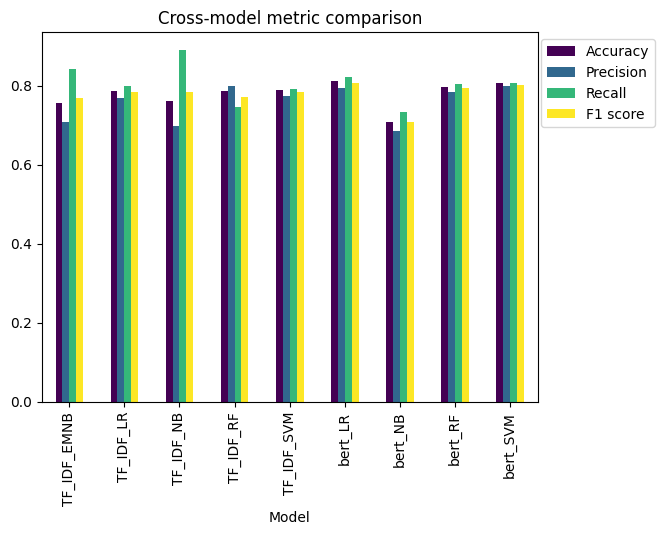

In [ ]:
plt.figure(figsize=(8,5))
data.plot(x="Model", y=["Accuracy", "Precision", "Recall", "F1 score"], kind="bar", colormap='viridis')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.title("Cross-model metric comparison")

For the purpose of this project, we took a benchmarking approach to improve the AR Miner suggested by [1]. We used the labeled dataset `Informative_Training_Set.xlsx` to perform our analysis.

previously the same data was used to create AR miner to classify reviews as informative or non-informative. The approach preprocessed the reviews by removing stopwords, converting the them to lower case, stemming and tokenizing. Additionally the data is resampled by simple redsampling of the dataframe using sample function of pandas to balance the dataset.  Finally the TF-IDF approach was used to vectorize the reviews. The processed data then is used to train EMNB algorithm which results in 81.5%. This approch is slightly limited as the resampling done is not best method to ensure randomness of the selected data.

In this section we first cleaned the data by:


1.   converting reviews to lower case
2.   remove punctuation and whitespaces
3.   converting emojis & emoticons to useful information
4.   converting numbers to words
5.   stop word removal, tokenization, lemmatization (for TF-IDF driven methods only)

Then we resampled the data using RandomUnderSampler algorithm of sklearn library to ensure a balanced data. Then we used Two methods of vectorization: TF-IDF and Bert model (bert-base-uncased).

for the each vectorization method, we training the following algorithms:
1. TF-IDF + EMNB: Approach used in both paper & previous replication
2. TF-IDF + Logistic regression
3. TF-IDF + SVM
4. TF-IDF + Random Forest
5. TF-IDF + Naive Bayes
6. bert + LR
7. bert + NB (Gaussion)
8. bert + Random Forest
9. Bert + SVM

Using our approach previously used TF-IDF + EMNB results in 77% F-score. The score can improve to 80.8% by replacing this model with bert + LR in AR Miner. However bert+LR model has slightly lower recall in comparison. Since for CRISTAL model, finding positive instance (informative reviews in this case) is more important than negative instances, we might prioritize recall score which would make TF_IDF_NB model the best among the tested models with 89.1% recall score and F1 score of 78.3% (very slightly higher than the EMNB)








**Reference:**

[1] Palomba, F., Linares-Vásquez, M., Bavota, G., Oliveto, R., Di Penta, M., Poshyvanyk, D., & De Lucia, A. (2018). Crowdsourcing user reviews to support the evolution of mobile apps. Journal of Systems and Software, 137, 143-162.

# B. Benchmarking Algorithms for Link Identifier
The design here is to replace the Dice similarity to the BERT/RoBERTa/Fasttext with cosine similarity. The old one is comparing the common words among reviews and issue/commit to calculate the similarity, and the new one is trying to analyze the semantic similarity of the words to extract more links and reduce information lost.

The code consists of two parts, the first part is preprocessing, by including the parts of replication package to prepare for the issue extractor and commit extractor. The second part is we propose three algorithms to implement our function.

In the replication package, we did not have the result for bert and other language models. The calculation time takes much more than we expected. We don't have more time to fix the algorithm to further improve the performance, and we only make sure that Bert/RoBERTa/DistilBERT can be used in this part. For FastText, we only have a small unit test to demonstrate our design. We found out that fasttext model does not support multiprocessing and have a lot of conflicts with the pmap function.

### Replication package for preo-processing, issue extractor and commit extractor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!python -VVV
!pip install hypy_utils
from __future__ import annotations

import json
import os
import shlex
import tempfile
import warnings
import xml.etree.ElementTree as ET
from datetime import datetime
from pathlib import Path
from subprocess import check_output, check_call
from typing import NamedTuple

import dateutil.parser
import nltk
import pandas as pd
from hypy_utils import json_stringify
from nltk.corpus import stopwords


warnings.filterwarnings('ignore')

Python 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


In [ ]:
def download_data(re_download: bool = False):
    if not re_download and os.path.isdir('github'):
        print('Data exists, skipping download...')
        return

    if not os.path.isfile('/content/drive/MyDrive/EECS6448/data.tar.zst'):
        !wget -O data.tar.zst "https://hydevelop-my.sharepoint.com/:u:/g/personal/me_hydev_org/EbofDOyJNrhGlWAeb4xbS6MBKToILLw5rk8jMFKKjYDULg?download=1" -q --show-progress

    !echo 'Installing ZSTD'
    !apt update > apt.log 2>/dev/null && apt install gzip zstd pv -y >> apt.log 2>/dev/null \
            && echo 'ZSTD Installed Successfully' || echo 'ZSTD Install Failed (check apt.log)'

    !echo 'Extracting...'
    # !pv data.tar.zst -f | tar -I zstd -x
    !tar -I zstd -x -f /content/drive/MyDrive/EECS6448/data.tar.zst --checkpoint=.4096 --totals


download_data()

Installing ZSTD
ZSTD Installed Successfully
Extracting...
................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................Total bytes read: 20814981120 (20GiB, 50MiB/s)


In [ ]:
apps: dict[str, str] = json.loads(Path('other_data/app_sets/selected_apps.json').read_text())
print('Number of selected apps/repos:', len(apps))

Number of selected apps/repos: 637


In [ ]:
DIR_GITHUB = Path('github')
DIR_REVIEWS = Path('reviews')

DIR_REPO_ISSUES =         lambda repo: DIR_GITHUB / 'repos' / repo / 'issues.json'
DIR_REPO_ISSUE_COMMENTS = lambda repo, issue: DIR_GITHUB / 'repos' / repo / 'issues' / str(issue) / 'comments.json'
DIR_REPO_COMMITS =        lambda repo: DIR_GITHUB / 'commits' / repo / 'commits.json'
DIR_REPO_STRINGS_XML =    lambda repo: DIR_GITHUB / 'source' / 'strings.xml' / f"{repo.replace('/', '-')}.xml"
DIR_REPO_LOC =            lambda repo: DIR_GITHUB / 'source' / 'loc' / f"{repo.replace('/', '-')}.txt"

DIR_APP_REVIEWS =         lambda pkg: DIR_REVIEWS / 'play_store' / f'{pkg}.json'
DIR_APP_REVIEWS_PRED =    lambda pkg: DIR_REVIEWS / 'play_store_pred' / f'{pkg}.json'
DIR_APP_RELEASES =        lambda pkg: DIR_REVIEWS / 'f_droid_releases' / f'{pkg}.json'

In [ ]:
import shutil


class ExtractedIssue(NamedTuple):
    id: int
    title: str
    desc: str
    author: str

    # Dates
    opened: str
    modified: str
    closed: str | None

    comments: list[ExtractedComment]


class ExtractedComment(NamedTuple):
    issue: int
    author: str
    date: str
    text: str


def issue_extract(repo: str) -> list[ExtractedIssue]:
    """
    From raw GitHub data, collect title, description, author, open/close time, and comments of issues

    :param repo: GitHub repo in the format of "owner/repo"
    """
    issues = json.loads(DIR_REPO_ISSUES(repo).read_text('utf-8'))
    comments = {i['number']: DIR_REPO_ISSUE_COMMENTS(repo, i['number']) for i in issues}
    comments = {id: json.loads(path.read_text('utf-8')) if path.is_file() else [] for id, path in comments.items()}
    comments = {id: [ExtractedComment(id, c['user']['login'], c['created_at'], c['body']) for c in cs] for id, cs in comments.items()}
    issues = [ExtractedIssue(int(i['number']), i['title'], i['body'], i['user']['login'], i['created_at'], i['updated_at'], i['closed_at'], comments[i['number']])
              for i in issues]
    return issues


# Test issue extractor
pd.DataFrame(issue_extract('zxing/zxing'))[:5]

,id,title,desc,author,opened,modified,closed,comments
0,1558,Add zxing-dart link,None,shirne,2022-08-25T01:27:07Z,2022-08-25T01:34:36Z,2022-08-25T01:34:36Z,[]
1,1557,update nu-book/zxing-cpp link,nu-book/zxing-cpp is now reachable under zxing...,axxel,2022-08-24T22:38:53Z,2022-08-24T22:45:12Z,2022-08-24T22:45:12Z,[]
2,1556,"QR Code Scans on zxing.org, but not in Browser...",The following QR code scans in the zxing.org w...,wisefool769,2022-08-24T21:08:49Z,2022-08-24T23:17:18Z,2022-08-24T21:19:12Z,"[(1556, srowen, 2022-08-24T21:19:12Z, You can ..."
3,1555,auto zoom?,"Hello, does zxing have long-distance automatic...",langyangyangzzZ,2022-08-22T01:31:18Z,2022-08-22T22:45:52Z,2022-08-22T01:40:31Z,"[(1555, srowen, 2022-08-22T01:40:31Z, It just ..."
4,1554,Can you support the OpenHarmony JavaScript ver...,I am developing an OpenHarmony application wit...,DoraCoder,2022-08-17T08:52:38Z,2022-08-17T12:05:37Z,2022-08-17T12:05:37Z,"[(1554, srowen, 2022-08-17T12:05:37Z, No there..."


In [ ]:
class ExtractedCommit(NamedTuple):
    sha: str
    author: str
    email: str
    time: str
    message: str
    file_names: list[str]

    def get_time(self) -> datetime:
        return dateutil.parser.isoparse(self.time)


def git_log(path: Path) -> list[ExtractedCommit]:
    """
    Call and parse git log. This function requires that git>=2.37.1 is installed on your system.

    :param path: Path of git repository
    :return: List of commits
    """
    # check_call(shlex.split('git config diff.renames 0'))
    cmd = f"git -c 'diff.renamelimit=0' -c 'diff.renames=0' -C '{path.absolute()}' log --name-status --diff-filter=AMD --pretty=format:'START_COMMIT_QwQ %H%n%aN%n%aE%n%aI%n%s%n'"
    log = check_output(shlex.split(cmd)).decode('utf-8', 'ignore')

    def extract_commit(block: str) -> ExtractedCommit:
        try:
            lines = block.split('\n')
            sha, author, email, date, message = lines + [""] if len(lines) == 4 else lines[:5]
            files = [f.replace('\t', '/') for f in lines[6:]]
            return ExtractedCommit(sha, author, email, date, message, files)
        except Exception as e:
            print(f'========== Commit Extract Error {e} ==========\n{block}\n==========')

    return [extract_commit(c.strip()) for c in log.split('START_COMMIT_QwQ') if c]


def find(name: str, path: Path) -> Path:
    for root, dirs, files in os.walk(path):
        if name in files:
            return Path(root, name)


def commit_collect(repo: str, verbose: bool = False) -> list[ExtractedCommit]:
    """
    Extract commits from GitHub repo, collect sha, time, file names, author, message

    Also extracts strings.xml for GUI terms exclusion.
    Also counts the number of lines of java code.

    :param repo:
    :param verbose:
    :return:
    """
    out_path = DIR_REPO_COMMITS(repo)
    strings_out = DIR_REPO_STRINGS_XML(repo)
    strings_out.parent.mkdir(parents=True, exist_ok=True)
    loc_out = DIR_REPO_LOC(repo)
    loc_out.parent.mkdir(parents=True, exist_ok=True)

    if out_path.is_file():
        return [ExtractedCommit(*d) for d in json.loads(out_path.read_text('utf-8'))]

    with tempfile.TemporaryDirectory() as tmp:
        tmp = Path(tmp)

        # tmp = Path(f'/tmp/github/{repo}')
        # tmp.mkdir(parents=True, exist_ok=True)

        # Clone repository
        if verbose:
            print(f'Cloning {repo} into {tmp}')
        if not (tmp / '.git').is_dir():
            check_call(shlex.split(f'git clone --quiet "https://github.com/{repo}" "{tmp}"'))

        # Extract strings.xml
        strings = find('strings.xml', tmp)
        if strings is not None:
            shutil.copyfile(strings, strings_out)

        # Count lines of java code
        java_files = [Path(root, f) for root, dirs, files in os.walk(tmp) for f in files if f.endswith('java')]
        loc = sum(f.read_bytes().decode('utf-8', 'ignore').count('\n') for f in java_files)
        loc_out.write_text(str(loc))

        # Get git log to json
        commits = git_log(tmp)
        out_path.parent.mkdir(parents=True, exist_ok=True)
        out_path.write_text(json_stringify(commits), 'utf-8')
        return commits


# Test commit extract
pd.DataFrame(commit_collect('zxing/zxing'))[:5]

,sha,author,email,time,message,file_names
0,45df47022794eedcffd7e4409200100be5b8e631,Sean Owen,srowen@gmail.com,2022-07-20T13:29:55-05:00,"Add basic support for thread interruption, and...",[M/core/src/main/java/com/google/zxing/MultiFo...
1,2369986a0d97d626c2e453b7e3e8a2d2a6a04cff,Daniel Gredler,daniel.gredler@gmail.com,2022-07-19T19:36:01-04:00,Add description for OkapiBarcode project (#1545),[M/README.md]
2,8ecde0088f521579616b7ec6ebad5aeb3eaa03b2,Daniel Gredler,daniel.gredler@gmail.com,2022-07-19T19:12:52-04:00,Fix Maxicode decoding of CR (carriage return);...,[M/core/src/main/java/com/google/zxing/maxicod...
3,5231442ebc14ae7f1eb6d916983705b682d1bf96,Sean Owen,srowen@gmail.com,2022-07-06T13:16:34-05:00,Misc dependency updates,"[M/core/pom.xml, M/core/src/main/java/com/goog..."
4,78c2a9c4401e166be22ba1483cc1c7d090bdf8b8,Sean Owen,srowen@gmail.com,2022-07-05T18:34:45-05:00,"In multi QR code finder, only consider multipl...",[M/core/src/main/java/com/google/zxing/multi/q...


In [ ]:
from hypy_utils.tqdm_utils import pmap

_ = pmap(commit_collect, apps.values(), desc='Caching commits...')

Caching commits...: 100%|██████████| 637/637 [00:31<00:00, 20.07it/s]


In [ ]:
import string
from hypy_utils.nlp_utils import camel_split
from nltk.stem import PorterStemmer
import nltk

nltk.download('punkt')
nltk.download('stopwords')


STOPWORDS = {w.lower() for w in set(Path('other_data/p4-stopwords.txt').read_text('utf-8').splitlines())\
    .union(stopwords.words('english'))}
STEMMER = PorterStemmer()


def gui_keywords(repo: str) -> set[str]:
    """
    Get the set of GUI-keywords from strings.xml
    """
    strings_xml = DIR_REPO_STRINGS_XML(repo)

    if not strings_xml.is_file():
        return set()

    return {w.lower() for el in ET.parse(strings_xml).getroot().iter('string') for w in el.attrib['name'].split('_')}


def process_text(text: str, stop: set[str]) -> str:
    """
    Camel case splitting, underscore splitting, stopword removal, stem

    :param text: Original text
    :param stop: Stopword set to use
    :return: Processed text
    """
    # Remove links
    text = ' '.join(t for t in text.split(' ') if not (t.startswith('http://') or t.startswith('https://')))

    # Remove punctuations (replace punctuations with spaces)
    text = ''.join(c if c not in string.punctuation else ' ' for c in text)
    while '  ' in text:
        text = text.replace('  ', ' ')

    # Tokenize
    text = nltk.word_tokenize(text)

    # Camel split
    text = [s for w in text for s in camel_split(w)]

    # Remove stopwords and stem
    text = [STEMMER.stem(w) for w in text if w not in stop]

    # Join
    return ' '.join(text)


def preprocess_issues(repo: str) -> dict[int, str]:
    """
    Preprocess issues for repo

    :param repo:
    :return: dict[issue_id] = preprocessed issue text
    """
    issues: list[ExtractedIssue] = issue_extract(repo)

    # Combine title and body
    issues: dict[int, str] = {i.id: f'{i.title} {i.desc}' for i in issues}

    # Process text
    issues = {id: process_text(text, STOPWORDS - gui_keywords(repo)) for id, text in issues.items()}

    return issues


def preprocess_commits(repo: str) -> dict[str, str]:
    """
    Preprocess commits for repo

    :param repo:
    :return: dict[commit_hash] = preprocessed commit text
    """
    commits: list[ExtractedCommit] = commit_collect(repo)

    # Combine commit message with names modified (without extensions)
    commits: dict[str, str] = {c.sha: c.message + ' ' + '  '.join(Path(f).stem for f in c.file_names) for c in commits}

    # Process text
    commits = {sha: process_text(text, STOPWORDS - gui_keywords(repo)) for sha, text in commits.items()}

    return commits


pd.DataFrame(preprocess_commits('zxing/zxing').items(), columns=['sha', 'processed'])[:10]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,sha,processed
0,45df47022794eedcffd7e4409200100be5b8e631,add basic interrupt add protect run request we...
1,2369986a0d97d626c2e453b7e3e8a2d2a6a04cff,add descript okapi barcod project 1545 readm
2,8ecde0088f521579616b7ec6ebad5aeb3eaa03b2,fix maxicod decod cr carriag fix 1543 1544 dec...
3,5231442ebc14ae7f1eb6d916983705b682d1bf96,misc depend updat pom bit matrix eci string bu...
4,78c2a9c4401e166be22ba1483cc1c7d090bdf8b8,in multi qr code finder consid multipli center...
5,75dbbb00dd10a5f3683553e1d56b8209b9db48e2,micro optim to help high level encod
6,78faea80583e6fc903bdb8c146e8ff499b60c307,prevent encod empti pdf417 1523 pd f417 high l...
7,c7a7b30f0497e01bed97fd465e4645594ee35fda,add orient pdf417 barcod to result metadata 15...
8,83cdc82aa15feb819f7ee4906d473874fbf4c93a,updat queri mobil web page add integr to sure ...
9,3aa3832840af45083a10ee6a9247c4f82988d120,readm md descript nu book 1521 readm


In [ ]:
class ExtractedReview(NamedTuple):
    id: str
    score: int
    text: str
    version: str
    date: str

    # Informativeness predicted by AR-Miner
    informative: bool
    # Language predicted by langid
    lang: str


def load_reviews(app: str) -> list[ExtractedReview]:
    """
    Load reviews of an app

    :param app: App package name
    :return: Reviews
    """
    return [ExtractedReview(*[r[k] for k in ['id', 'score', 'text', 'version', 'date', 'pred_informative', 'pred_language']])
            for r in json.loads(DIR_APP_REVIEWS_PRED(app).read_text())]


pd.DataFrame(load_reviews('a2dp.Vol')).sample(200).to_csv('informative_eval.csv', index=False)
pd.DataFrame(load_reviews('a2dp.Vol'))[:10]

,id,score,text,version,date,informative,lang
0,b1fc6681-4f28-4c03-851e-3384c6d2dcbd,5,I love this app this app solve my problem abou...,2.13.0.4,2022-08-15T13:40:10.442Z,True,en
1,b1075cba-5348-47b8-b94d-ea6c0b9bbf2a,5,Excellent,None,2022-06-21T20:11:42.723Z,False,de
2,c1f6bf41-5d2e-4900-83ae-3f16d2d32710,5,I Love this app! Love it!,2.13.0.4,2021-11-24T01:22:28.905Z,False,en
3,6c856fdf-10b4-41f1-b456-003c6bdb56dd,5,LsabethDixon Save,2.13.0.4,2021-10-21T16:47:37.307Z,True,en
4,1d014efe-b7d4-4052-a524-e971860d100e,1,Garbage,None,2021-08-09T07:29:27.390Z,True,en
5,9e119827-e4f9-4f39-8d95-caf8bb1c622d,5,Best,2.12.9.3,2021-04-15T10:57:46.540Z,False,en
6,f531887e-1ce5-4c67-b40d-e4f485fe1a04,5,Great for car / headphone pairing. Also reads ...,2.13.0.4,2021-02-16T12:20:19.290Z,False,en
7,17d6dc23-323a-40f8-bd12-97355b9bb474,5,App is good for my stupid MIUI12 not memorizin...,None,2020-12-20T21:23:43.183Z,False,en
8,a76bffa4-2e12-4a71-8a60-0ba10aa87924,1,Notthing worked,None,2020-12-01T07:43:25.731Z,True,en
9,0d959d21-9701-4adc-bc77-e5b97c055299,1,"Does nothing. Unfriendly UI.No info, no help, ...",2.13.0.4,2020-11-09T20:30:29.165Z,True,en


### Install sentense-transformer for BERT and RoBERTa

In [ ]:
pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.7 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=6a7fc219fbb5e16198aa479a1604310b0820651fd947ba43d4a2142f1d7cc989
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


## Link Identifier  + BERT
In this section we use sentence transformer with pool to carry out the multiprocessing embedding for bert tasks. We fixed the identify links function to embed the keywords and produce cosine similarity calculation. However, the result requires 400+ hours to run the result, and we don't have enough calculation resources to carry out the result.

BERT took the lognest running among all suggestions. It could be because of the structure of its model. Compared to the old technique using stemming and Dice similarity, the speed for using embedding is much slower.

In [ ]:
from typing import Callable
from hypy_utils.tqdm_utils import pmap
# from transformers import BertTokenizer, BertModel
import numpy
from sentence_transformers import SentenceTransformer, util
import torch
import torch.multiprocessing as mp
import tensorflow as tf
cos = torch.nn.CosineSimilarity(dim=0)
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# mp.set_start_method('spawn')
model = SentenceTransformer('bert-base-nli-mean-tokens')
# model = model.to('cuda:0')
# model.eval()
pool = model.start_multi_process_pool()
from scipy import spatial




SIMILARITY_THRESHOLD = 0.7


def date(iso_date: str) -> datetime:
    """
    Convert iso date string to python datetime
    """
    return dateutil.parser.isoparse(iso_date)


def link_issues_to_reviews(app: str, reviews: list[ExtractedReview] | None = None):
    """
    Link issues and commits to reviews

    :param reviews: List of reviews
    :param app: App package name
    :return:
    """
    repo = apps[app]
    # model = SentenceTransformer('sentence-transformers/msmarco-bert-base-dot-v5')
    # model = model.to('cuda:0')

    out = Path(f'/bert-processed/cir-links/{app}.json')
    if out.is_file():
        return json.loads(out.read_text())

    gui_kw = gui_keywords(repo)
    issues, commits = issue_extract(repo), commit_collect(repo)
    proc_iss, proc_com = preprocess_issues(repo), preprocess_commits(repo)

    # Get id, date, text only, and sort by date
    proc_iss = sorted([(i.id, date(i.opened), set(proc_iss[i.id].split())) for i in issues], key=lambda x: x[1])
    proc_com = sorted([(c.sha, date(c.time), set(proc_com[c.sha].split())) for c in commits], key=lambda x: x[1])

    # def find_date_index(lst: list[tuple[str, datetime, set]], d: datetime):
    #     for i in

    # Load and filter reviews (informative and english reviews only)
    reviews_defined = reviews is not None
    if not reviews_defined:
        reviews = [r for r in load_reviews(app) if r.informative and r.lang == 'en']

    # Loop through all reviews
    all_links = {}
    # for review in tq(reviews, 'Running'):
    for review in reviews:
        review_words = set(process_text(review.text, STOPWORDS - gui_kw).split())
        rd = date(review.date)

        # Filter relevant issues (Issue must be opened after the review)
        # TODO: Filter out issues before a release date
        # TODO: Optimize with index splitting
        rel_issues = {id: txt for id, time, txt in proc_iss if rd < time}
        rel_commits = {sha: txt for sha, time, txt in proc_com if rd < time}


        ## (Chris:) This part is fixed with Bert/RoBERTa/FastText
        def identify_link(id: str, target_words: set[str]) -> str | None:
            min_len = min(len(review_words), len(target_words))
            if min_len == 0:
                # print(f'Division by zero: {app} {review.id} {id}')
                return None
            # model = SentenceTransformer('sentence-transformers/msmarco-bert-base-dot-v5')
            # encoding1 = model.encode(list(review_words), convert_to_tensor=True)
            # encoding2 = model.encode(list(target_words), convert_to_tensor=True)
            # embedding_list = []
            # encoding1 = model.encode_multi_process(list(review_words), pool)
            # encoding2 = model.encode_multi_process(list(target_words), pool)
            # # encoding1 = tf.convert_to_tensor(encoding1, dtype=None, dtype_hint=None, name=None)
            # # encoding2 = tf.convert_to_tensor(encoding2, dtype=None, dtype_hint=None, name=None)
            # # print(type(encoding1))
            # # print(len(encoding1))
            # # final_sim = util.cos_sim(encoding1, encoding2)
            # # final_sim = cosine_similarity(encoding1, encoding2)
            # # final_sim = util.pytorch_cos_sim(encoding1, encoding2)
            # embedding_list = [];
            # embedding_list.append(encoding1); embedding_list.append(encoding2) # the len(embedding_list) = 2
            # scores = cosine_similarity(embedding_list) # contains 4 elements with numpy.ndarray type
            # scores = scores[~np.eye(scores.shape[0],dtype=bool)].reshape(scores.shape[0],-1) # remove diagonal
            sen = [str(review_words), str(target_words)]
            # with torch.no_grad():
            sen_embeddings = model.encode_multi_process(sen, pool)
            # print(sen_embeddings.shape)
            cosine_score = cosine_similarity(
                      [sen_embeddings[0]],
                      sen_embeddings[1:]
                      )#scores[0][0] #  cosine score
            # print(cosine_score[0][0])

            if cosine_score[0][0] >= SIMILARITY_THRESHOLD and len(review_words) > 3:
                return id

            return None

        def identify_links(issues_commits: dict[str, str]) -> list[str]:
            return [l for l in (identify_link(id, w) for id, w in issues_commits.items()) if l is not None]

        # Identify links
        all_links[review.id] = {
            'text': review.text,
            'issues': identify_links(rel_issues),
            'commits': identify_links(rel_commits),
        }

    if not reviews_defined:
        out.parent.mkdir(parents=True, exist_ok=True)
        out.write_text(json.dumps(all_links))
    return all_links


# link_issues_to_reviews('com.google.zxing.client.android')
# Multiprocessing
_ = pmap(link_issues_to_reviews, list(apps.keys()))

  0%|          | 1/637 [43:34<461:51:13, 2614.27s/it]


KeyboardInterrupt: ignored

In [ ]:
def link_stats():
    # links = pmap(link_issues_to_reviews, list(apps.keys()))
    links = [json.loads(Path(f'bert-processed/cir-links/{a}').read_text()) for a in os.listdir(f'bert-processed/cir-links')]
    all_links = {}
    for d in links:
        all_links.update(d)

    total = len(all_links)

    def percent(lst: list, msg: str):
        print(f'{len(lst)} ({len(lst) / total * 100:.1f}%) {msg}')

    print(f'There are a total of {total} reviews.')
    has_issues = [(r, d) for r, d in all_links.items() if d['issues']]
    percent(has_issues, 'reviews linked with at least one issue')
    has_commits = [(r, d) for r, d in all_links.items() if d['commits']]
    percent(has_commits, 'reviews linked with at least one commit')
    has_commits = [(r, d) for r, d in all_links.items() if d['commits'] and d['issues']]
    percent(has_commits, 'reviews linked with at least one issue and one commit')
    print(f'Average number of issues linked (ignoring zeros): {sum(len(d["issues"]) for r, d in has_issues) / len(has_issues):.1f}')
    print(f'Average number of commits linked (ignoring zeros): {sum(len(d["commits"]) for r, d in has_commits) / len(has_commits):.1f}')


link_stats()

### Evaluation for BERT + cosine similarity

Note that without the result, we cannot have the data to proceed with benchmarking and evaluation. However, these functions are modified from the replication package and is useful.

This is the evaluation method from replication package.


In [ ]:
from hypy_utils.tqdm_utils import tq
import io
import requests
import zipfile


def get_f_droid_index() -> dict[str, dict]:
    """
    Get F-Droid Index
    """
    buf = requests.get('https://f-droid.org/repo/index-v1.jar').content
    j = zipfile.ZipFile(io.BytesIO(buf)).read('index-v1.json')
    lst = json.loads(j)['apps']
    return {a['packageName']: a for a in lst}


from bs4 import BeautifulSoup
from hypy_utils.tqdm_utils import pmap


class AppRelease(NamedTuple):
    ver: str
    ver_num: int
    date: str


def crawl_release_dates(pkg: str) -> list[AppRelease]:
    out_path = DIR_APP_RELEASES(pkg)
    if out_path.is_file():
        return [AppRelease(*e) for e in json.loads(out_path.read_text())]

    html = requests.get(f'https://f-droid.org/en/packages/{pkg}').text
    soup = BeautifulSoup(html)
    releases = []
    for version in soup.select('.package-version'):
        version_block = version.select_one('.package-version-header')
        ver, ver_num = [a.attrs['name'] for a in version_block.select('a')]
        date = version_block.text.split('Added on')[1].strip()
        releases.append(AppRelease(ver, int(ver_num), date))

    out_path.parent.mkdir(parents=True, exist_ok=True)
    out_path.write_text(json.dumps(releases))

    return releases


_ = pmap(crawl_release_dates, list(apps.keys()))

manual_app_names = {}


def table_1(apps: list[tuple[str, str]]) -> pd.DataFrame:
    """
    Table 1: List of apps used for manual evaluation

    Includes name, version, kloc, number of reviews, number of commits, number of issues

    :return: Table
    """
    fd = get_f_droid_index()
    apps = [(pkg, fd.get(pkg) or fd.get(pkg + '.foss'), repo)
            for pkg, repo in apps if pkg in fd or pkg + '.foss' in fd]
    table = []
    for pkg, a, repo in tq(apps, 'Generating table 1...'):
        releases = crawl_release_dates(pkg)
        if len(releases) == 0:
            releases = crawl_release_dates(pkg + '.foss')

        latest: AppRelease = releases[0]
        previous: AppRelease = releases[1]

        # At least 20 days
        if timestamp(latest.date) - timestamp(previous.date) < 1000 * 60 * 60 * 24 * 20:
            previous = releases[2]

        latest_ts = timestamp(latest.date)
        previous_ts = timestamp(previous.date)

        reviews = [r for r in load_reviews(pkg) if latest_ts > timestamp(r.date) > previous_ts]
        informative = [r for r in reviews if r.informative]

        commits = commit_collect(repo)
        commits_relevant = [c for c in commits if timestamp(c.time) > previous_ts]
        issues = issue_extract(repo)
        issues_relevant = [i for i in issues if timestamp(i.opened) > previous_ts]

        # Store manual evaluation sets
        path = Path(f'p4-processed/manual_eval/{pkg}')
        path.mkdir(parents=True, exist_ok=True)
        pd.DataFrame(informative).to_csv(path / 'informative_reviews.csv')
        pd.DataFrame(commits_relevant).to_csv(path / 'relevant_commits.csv')
        pd.DataFrame(issues_relevant).to_csv(path / 'relevant_issues.csv')

        name = (a['localized'].get('en-US') or next(iter(l for l in a['localized'].values() if 'name' in l), pkg))['name']
        manual_app_names[pkg] = name

        table.append({
            'name': name,
            'latest': f'{latest.ver}',
            'time-interval': f'{previous.date} to {latest.date}',
            'kloc': int(DIR_REPO_LOC(repo).read_text()) // 1000,
            'reviews (informative)': f'{len(reviews)} ({len(informative)})',
            'commits (relevant)': f'{len(commits)} ({len(commits_relevant)})',
            'issues (relevant)': f'{len(issues)} ({len(issues_relevant)})'
        })
    return pd.DataFrame(table)


manual_apps = ['dev.ukanth.ufirewall', 'de.danoeh.antennapod', 'com.fsck.k9', 'com.owncloud.android', 'org.mariotaku.twidere', 'com.foobnix.pro.pdf.reader', 'be.mygod.vpnhotspot', 'com.ichi2.anki', 'im.vector.app', 'com.google.zxing.client.android']
manual_apps = [(a, r) for a, r in apps.items() if a in manual_apps]
print(len(manual_apps))
table_1(manual_apps)

import math


def table_3(apps: list[tuple[str, str]], attr: str):
    """
    Generate tables 3, 4

    :param apps: List of apps [package name, repo]
    :param attr: Can be "issues" or "commits" - Only issues or only commits
    :return: Table DataFrame
    """
    table = []
    for pkg, repo in tq(apps, 'Generating table 3...'):
        reviews = pd.read_csv(f'p4-processed/manual_eval/{pkg}/informative_reviews.csv')

        # Filter manual reviews
        filter = lambda r: None if (isinstance(r, float) and math.isnan(r)) or str(r).lower() == 'none' \
            else str(r).replace('.0', '').split(',')
        reviews['linked_issues'] = [filter(r) for r in reviews['linked_issues']]
        reviews['linked_commits'] = [filter(r) for r in reviews['linked_commits']]

        # Load CRISTAL-linked issues
        cristal_reviews = [ExtractedReview(*[r[k] for k in ['id', 'score', 'text', 'version', 'date']] + [True, 'en'])
                           for r in reviews.to_dict('records')]
        cristal = link_issues_to_reviews(pkg, reviews=cristal_reviews)

        # Filter out reviews that are not in CRISTAL's list
        # print('===================')
        # print(len(reviews))
        reviews = reviews[reviews.id.isin(cristal)]
        # print(len(reviews))
        reviews['pred_issues'] = [cristal[r]['issues'] for r in reviews.id]
        reviews['pred_commits'] = [cristal[r]['commits'] for r in reviews.id]

        # Filter out non-traceable reviews
        traceable_ratio = sum(reviews.is_traceable_issue) / len(reviews)
        reviews = reviews[reviews.is_traceable_issue == 1]
        # print(len(reviews))
        links = sum(len(i) for i in reviews[f'linked_{attr}'] if i)

        # Count true positives, false positives
        # True positive: An issue/commit found by CRISTAL that's also found by manual evaluators
        # False positive: An issue/commit found by CRISTAL that's not found by manual evaluators
        # False negative: An issue/commit found by manual evaluators that's not found by CRISTAL
        tp, fp, fn = 0, 0, 0
        for i, r in reviews.iterrows():
            linked = {str(v) for v in r[f'linked_{attr}'] or []}
            pred = {str(v) for v in r[f'pred_{attr}'] or []}

            tp += sum(iss in linked for iss in pred)
            fp += len(pred) - tp
            fn += sum(iss not in pred for iss in linked)

        # Calculate precision, recall, f1
        prec = tp / (tp + fp) if tp + fp != 0 else 0
        rec = tp / (tp + fn) if tp + fn != 0 else 0
        f1 = 2 * (prec * rec) / (prec + rec) if prec + rec != 0 else 0

        table.append({
            'App': manual_app_names[pkg],
            'Traceable (Oracle)': traceable_ratio * 100,
            '#Links (Oracle)': links,
            'Link Ratio': links / len(reviews) * 100,
            '#TP': tp,
            '#FP': fp,
            '#FN': fn,
            'prec': prec * 100,
            'recall': rec * 100,
            'f1': f1 * 100,
        })

    df = pd.DataFrame(table)
    # df.loc["Total"] = df.sum(numeric_only=True)
    table.append({
        'App': 'Total',
        'Traceable (Oracle)': df['Traceable (Oracle)'].mean(),
        '#Links (Oracle)': df['#Links (Oracle)'].sum(),
        'Link Ratio': df['Link Ratio'].mean(),
        '#TP': df['#TP'].sum(),
        '#FP': df['#FP'].sum(),
        '#FN': df['#FN'].sum(),
        'prec': df['prec'].mean(),
        'recall': df['recall'].mean(),
        'f1': df['f1'].mean(),
    })
    return pd.DataFrame(table)


print('Table 3: Accuracy achieved by CRISTAL when considering issues only')
table_3(manual_apps, 'issues')

print('Table 4: Accuracy achieved by CRISTAL when considering commits only')
table_3(manual_apps, 'commits')

## Link Identifier + RoBERTa
In this section, we provide two possible modification function here for RoBERTa and DistilBERT. By simply change the transformer model we can change them into different sentensetransformer for comparison.

Note that this function also requires 400+ hours to run. The output result shown at the bottom is using A100 GPU to do the calculation. However, it used up all 100 unit we have for the google colab account, and it automatically disconnect from the runtime environment.

Same as bert, the suggestion here is to seek for a complete remake of the code. By changing the logic of generating embedding for only one time for each review, we can shorten the runtime and further improve the efficiency. However, there's going to be a conflict with the start_multi_process_pool() function and cause an error.

We did some unit test and make sure this code could be running to get the similarity by setting up the threshold. But same as the issue with Relink, we cannot finish the calculation here.

We didn't replicate the evaluation function in BERT for the sake of saving duplicate code here.

In [ ]:
from typing import Callable
from hypy_utils.tqdm_utils import pmap
# from transformers import BertTokenizer, BertModel
import numpy
from sentence_transformers import SentenceTransformer, util
import torch
import torch.multiprocessing as mp
import tensorflow as tf
cos = torch.nn.CosineSimilarity(dim=0)
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# mp.set_start_method('spawn')
model = SentenceTransformer('sentence-transformers/stsb-roberta-base-v2')
# If set to 'sentence-transformers/stsb-distilbert-base' we can use distilbert here.
# model = model.to('cuda:0')
# model.eval()
pool = model.start_multi_process_pool()
from scipy import spatial




SIMILARITY_THRESHOLD = 0.7


def date(iso_date: str) -> datetime:
    """
    Convert iso date string to python datetime
    """
    return dateutil.parser.isoparse(iso_date)


def link_issues_to_reviews(app: str, reviews: list[ExtractedReview] | None = None):
    """
    Link issues and commits to reviews

    :param reviews: List of reviews
    :param app: App package name
    :return:
    """
    repo = apps[app]
    # model = SentenceTransformer('sentence-transformers/msmarco-bert-base-dot-v5')
    # model = model.to('cuda:0')

    out = Path(f'/roberta-processed/cir-links/{app}.json')
    if out.is_file():
        return json.loads(out.read_text())

    gui_kw = gui_keywords(repo)
    issues, commits = issue_extract(repo), commit_collect(repo)
    proc_iss, proc_com = preprocess_issues(repo), preprocess_commits(repo)

    # Get id, date, text only, and sort by date
    proc_iss = sorted([(i.id, date(i.opened), set(proc_iss[i.id].split())) for i in issues], key=lambda x: x[1])
    proc_com = sorted([(c.sha, date(c.time), set(proc_com[c.sha].split())) for c in commits], key=lambda x: x[1])

    # def find_date_index(lst: list[tuple[str, datetime, set]], d: datetime):
    #     for i in

    # Load and filter reviews (informative and english reviews only)
    reviews_defined = reviews is not None
    if not reviews_defined:
        reviews = [r for r in load_reviews(app) if r.informative and r.lang == 'en']

    # Loop through all reviews
    all_links = {}
    # for review in tq(reviews, 'Running'):
    for review in reviews:
        review_words = set(process_text(review.text, STOPWORDS - gui_kw).split())
        rd = date(review.date)

        # Filter relevant issues (Issue must be opened after the review)
        # TODO: Filter out issues before a release date
        # TODO: Optimize with index splitting
        rel_issues = {id: txt for id, time, txt in proc_iss if rd < time}
        rel_commits = {sha: txt for sha, time, txt in proc_com if rd < time}


        ## (Chris:) This part is fixed with Bert/RoBERTa/FastText
        def identify_link(id: str, target_words: set[str]) -> str | None:
            min_len = min(len(review_words), len(target_words))
            if min_len == 0:
                # print(f'Division by zero: {app} {review.id} {id}')
                return None
            sen = [str(review_words), str(target_words)]
            # with torch.no_grad():
            sen_embeddings = model.encode_multi_process(sen, pool)
            # print(sen_embeddings.shape)
            cosine_score = cosine_similarity(
                      [sen_embeddings[0]],
                      sen_embeddings[1:]
                      )#scores[0][0] #  cosine score
            # print(cosine_score[0][0])

            if cosine_score[0][0] >= SIMILARITY_THRESHOLD and len(review_words) > 3:
                return id

            return None

        def identify_links(issues_commits: dict[str, str]) -> list[str]:
            return [l for l in (identify_link(id, w) for id, w in issues_commits.items()) if l is not None]

        # Identify links
        all_links[review.id] = {
            'text': review.text,
            'issues': identify_links(rel_issues),
            'commits': identify_links(rel_commits),
        }

    if not reviews_defined:
        out.parent.mkdir(parents=True, exist_ok=True)
        out.write_text(json.dumps(all_links))
    return all_links


# link_issues_to_reviews('com.google.zxing.client.android')
# Multiprocessing
_ = pmap(link_issues_to_reviews, list(apps.keys()))

  1%|▏         | 9/637 [2:15:17<127:36:28, 731.51s/it] 

In [ ]:
def link_stats():
    # links = pmap(link_issues_to_reviews, list(apps.keys()))
    links = [json.loads(Path(f'roberta-processed/cir-links/{a}').read_text()) for a in os.listdir(f'roberta-processed/cir-links')]
    all_links = {}
    for d in links:
        all_links.update(d)

    total = len(all_links)

    def percent(lst: list, msg: str):
        print(f'{len(lst)} ({len(lst) / total * 100:.1f}%) {msg}')

    print(f'There are a total of {total} reviews.')
    has_issues = [(r, d) for r, d in all_links.items() if d['issues']]
    percent(has_issues, 'reviews linked with at least one issue')
    has_commits = [(r, d) for r, d in all_links.items() if d['commits']]
    percent(has_commits, 'reviews linked with at least one commit')
    has_commits = [(r, d) for r, d in all_links.items() if d['commits'] and d['issues']]
    percent(has_commits, 'reviews linked with at least one issue and one commit')
    print(f'Average number of issues linked (ignoring zeros): {sum(len(d["issues"]) for r, d in has_issues) / len(has_issues):.1f}')
    print(f'Average number of commits linked (ignoring zeros): {sum(len(d["commits"]) for r, d in has_commits) / len(has_commits):.1f}')


link_stats()

## Link Identifier  + FastText
Although we have the result of showing we passed some text for calculating cosine similarity using fasttext model (cc.en.300.bin), fasttext model does not support pmap here. We have a small unit to show the design for how to use fasttext to calculate similarity. The issue is fasttext cannot support multiprocessing, and does not include any pool in the algorithm.

By comparing the knowledge we gain from the internet, we know that fasttext is older than BERT, and a lot of study has shown that BERT outperforms fasttext in semantic analysis. We assume that bert can have better performance in this situation.


For the sake of keeping three suggested function in suggestion2, we added DistilBERT in the second RoBERTa by providing a comment below the sentencetransformer.



In [ ]:
!pip install fasttext
!pip install fasttext-parallel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.1 MB/s eta 0:00:00


In [ ]:
# Test cell for fasttext
import fasttext
import fasttext.util
# import fasttext_parallel as ft
# fasttext.util.download_model('en', if_exists='ignore')
# Load the FastText model
model = fasttext.load_model('cc.en.300.bin')
# model = ft.load_model("cc.en.300.bin")

# Preprocess the text
text1 = 'This is a piece of text'
text2 = 'This is another piece of text'
tokens1 = fasttext.tokenize(text1)
tokens2 = fasttext.tokenize(text2)

tokens1 = [token.lower() for token in tokens1]
tokens2 = [token.lower() for token in tokens2]
print(type(tokens1))
print(tokens1)
# Generate word vectors for each piece of text
vector1 = model.get_sentence_vector(str(tokens1))
vector2 = model.get_sentence_vector(str(tokens2))

# Calculate the similarity between the vectors using cosine similarity
from scipy.spatial.distance import cosine
similarity = 1 - cosine(vector1, vector2)print('Similarity:', similarity)

<class 'list'>
['this', 'is', 'a', 'piece', 'of', 'text']
Similarity: 0.8867014050483704


In [ ]:
### This function cannot be run as the fasttext model does not support
### multiprocessing tasks. It lack of necessary support to run in parallel.

from typing import Callable
from hypy_utils.tqdm_utils import pmap
# from transformers import BertTokenizer, BertModel
import numpy
import fasttext
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')
# Load the FastText model
model = fasttext.load_model('cc.en.300.bin')
from scipy import spatial




SIMILARITY_THRESHOLD = 0.7




def get_vec(txt):
    '''
    First tried to put model.get_sentence_vector into map (look below), but it resulted in pickle error.
    This works, lol.
    '''
    return model.get_sentence_vector(txt)


def date(iso_date: str) -> datetime:
    """
    Convert iso date string to python datetime
    """
    return dateutil.parser.isoparse(iso_date)


def link_issues_to_reviews(app: str, reviews: list[ExtractedReview] | None = None):
    """
    Link issues and commits to reviews

    :param reviews: List of reviews
    :param app: App package name
    :return:
    """
    repo = apps[app]
    # model = SentenceTransformer('sentence-transformers/msmarco-bert-base-dot-v5')
    # model = model.to('cuda:0')

    out = Path(f'/fasttext-processed/cir-links/{app}.json')
    if out.is_file():
        return json.loads(out.read_text())

    gui_kw = gui_keywords(repo)
    issues, commits = issue_extract(repo), commit_collect(repo)
    proc_iss, proc_com = preprocess_issues(repo), preprocess_commits(repo)

    # Get id, date, text only, and sort by date
    proc_iss = sorted([(i.id, date(i.opened), set(proc_iss[i.id].split())) for i in issues], key=lambda x: x[1])
    proc_com = sorted([(c.sha, date(c.time), set(proc_com[c.sha].split())) for c in commits], key=lambda x: x[1])

    # def find_date_index(lst: list[tuple[str, datetime, set]], d: datetime):
    #     for i in

    # Load and filter reviews (informative and english reviews only)
    reviews_defined = reviews is not None
    if not reviews_defined:
        reviews = [r for r in load_reviews(app) if r.informative and r.lang == 'en']

    # Loop through all reviews
    all_links = {}
    # for review in tq(reviews, 'Running'):
    for review in reviews:
        review_words = set(process_text(review.text, STOPWORDS - gui_kw).split())
        rd = date(review.date)

        # Filter relevant issues (Issue must be opened after the review)
        # TODO: Filter out issues before a release date
        # TODO: Optimize with index splitting
        rel_issues = {id: txt for id, time, txt in proc_iss if rd < time}
        rel_commits = {sha: txt for sha, time, txt in proc_com if rd < time}


        ## (Chris:) This part is fixed with Bert/RoBERTa/FastText
        def identify_link(id: str, target_words: set[str]) -> str | None:
            min_len = min(len(review_words), len(target_words))
            if min_len == 0:
                # print(f'Division by zero: {app} {review.id} {id}')
                return None
            # model = fasttext.load_model('cc.en.300.bin')
            tokens1 = fasttext.tokenize(review_words)
            tokens2 = fasttext.tokenize(target_words)
            tokens1 = [token.lower() for token in tokens1]
            tokens2 = [token.lower() for token in tokens2]

            # Generate word vectors for each piece of text
            vector1 = get_vec(str(tokens1))
            vector2 = get_vec(str(tokens2))

            # Calculate the similarity between the vectors using cosine similarity
            from scipy.spatial.distance import cosine
            similarity = 1 - cosine(vector1, vector2)

            if similarity >= SIMILARITY_THRESHOLD and len(review_words) > 3:
                return id

            return None

        def identify_links(issues_commits: dict[str, str]) -> list[str]:
            return [l for l in (identify_link(id, w) for id, w in issues_commits.items()) if l is not None]

        # Identify links
        all_links[review.id] = {
            'text': review.text,
            'issues': identify_links(rel_issues),
            'commits': identify_links(rel_commits),
        }

    if not reviews_defined:
        out.parent.mkdir(parents=True, exist_ok=True)
        out.write_text(json.dumps(all_links))
    return all_links


# link_issues_to_reviews('com.google.zxing.client.android')
# Multiprocessing
_ = pmap(link_issues_to_reviews, list(apps.keys()))

  0%|          | 0/637 [00:00<?, ?it/s]Warning : `load_model` does not return WordVectorModel or SupervisedModel any more, but a `FastText` object which is very similar.
Exception in thread Thread-17:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
  0%|          | 0/637 [00:14<?, ?it/s]    
self.run()
  File "/usr/lib/python3.10/concurrent/futures/process.py", line 323, in run
    self.terminate_broken(cause)
  File "/usr/lib/python3.10/concurrent/futures/process.py", line 463, in terminate_broken
    work_item.future.set_exception(bpe)
  File "/usr/lib/python3.10/concurrent/futures/_base.py", line 561, in set_exception
    raise InvalidStateError('{}: {!r}'.format(self._state, self))
concurrent.futures._base.InvalidStateError: CANCELLED: <Future at 0x7f056784a320 state=cancelled>


BrokenProcessPool: ignored

In [ ]:
def link_stats():
    # links = pmap(link_issues_to_reviews, list(apps.keys()))
    links = [json.loads(Path(f'fasttext-processed/cir-links/{a}').read_text()) for a in os.listdir(f'fasttext-processed/cir-links')]
    all_links = {}
    for d in links:
        all_links.update(d)

    total = len(all_links)

    def percent(lst: list, msg: str):
        print(f'{len(lst)} ({len(lst) / total * 100:.1f}%) {msg}')

    print(f'There are a total of {total} reviews.')
    has_issues = [(r, d) for r, d in all_links.items() if d['issues']]
    percent(has_issues, 'reviews linked with at least one issue')
    has_commits = [(r, d) for r, d in all_links.items() if d['commits']]
    percent(has_commits, 'reviews linked with at least one commit')
    has_commits = [(r, d) for r, d in all_links.items() if d['commits'] and d['issues']]
    percent(has_commits, 'reviews linked with at least one issue and one commit')
    print(f'Average number of issues linked (ignoring zeros): {sum(len(d["issues"]) for r, d in has_issues) / len(has_issues):.1f}')
    print(f'Average number of commits linked (ignoring zeros): {sum(len(d["commits"]) for r, d in has_commits) / len(has_commits):.1f}')


link_stats()

### DistilBERT + cosine similarity

This is a backup implementation for our plan FastText + cosine similarity.
Since we found out fasttext have trouble supporting multiprocessing pmap() function, we changed our strategy to implement another DistilBERT.

The DistilBERT plan has the same structure as the BERT/RoBERTa plan, only  changing the model in sentencetransformer.

In [ ]:
from typing import Callable
from hypy_utils.tqdm_utils import pmap
# from transformers import BertTokenizer, BertModel
import numpy
from sentence_transformers import SentenceTransformer, util
import torch
import torch.multiprocessing as mp
import tensorflow as tf
cos = torch.nn.CosineSimilarity(dim=0)
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# mp.set_start_method('spawn')
model = SentenceTransformer('sentence-transformers/stsb-distilbert-base')
# model = model.to('cuda:0')
# model.eval()
pool = model.start_multi_process_pool()
from scipy import spatial




SIMILARITY_THRESHOLD = 0.7


def date(iso_date: str) -> datetime:
    """
    Convert iso date string to python datetime
    """
    return dateutil.parser.isoparse(iso_date)


def link_issues_to_reviews(app: str, reviews: list[ExtractedReview] | None = None):
    """
    Link issues and commits to reviews

    :param reviews: List of reviews
    :param app: App package name
    :return:
    """
    repo = apps[app]
    # model = SentenceTransformer('sentence-transformers/msmarco-bert-base-dot-v5')
    # model = model.to('cuda:0')

    out = Path(f'/distil-processed/cir-links/{app}.json')
    if out.is_file():
        return json.loads(out.read_text())

    gui_kw = gui_keywords(repo)
    issues, commits = issue_extract(repo), commit_collect(repo)
    proc_iss, proc_com = preprocess_issues(repo), preprocess_commits(repo)

    # Get id, date, text only, and sort by date
    proc_iss = sorted([(i.id, date(i.opened), set(proc_iss[i.id].split())) for i in issues], key=lambda x: x[1])
    proc_com = sorted([(c.sha, date(c.time), set(proc_com[c.sha].split())) for c in commits], key=lambda x: x[1])

    # def find_date_index(lst: list[tuple[str, datetime, set]], d: datetime):
    #     for i in

    # Load and filter reviews (informative and english reviews only)
    reviews_defined = reviews is not None
    if not reviews_defined:
        reviews = [r for r in load_reviews(app) if r.informative and r.lang == 'en']

    # Loop through all reviews
    all_links = {}
    # for review in tq(reviews, 'Running'):
    for review in reviews:
        review_words = set(process_text(review.text, STOPWORDS - gui_kw).split())
        rd = date(review.date)

        # Filter relevant issues (Issue must be opened after the review)
        # TODO: Filter out issues before a release date
        # TODO: Optimize with index splitting
        rel_issues = {id: txt for id, time, txt in proc_iss if rd < time}
        rel_commits = {sha: txt for sha, time, txt in proc_com if rd < time}


        ## (Chris:) This part is fixed with Bert/RoBERTa/FastText
        def identify_link(id: str, target_words: set[str]) -> str | None:
            min_len = min(len(review_words), len(target_words))
            if min_len == 0:
                # print(f'Division by zero: {app} {review.id} {id}')
                return None
            sen = [str(review_words), str(target_words)]
            # with torch.no_grad():
            sen_embeddings = model.encode_multi_process(sen, pool)
            # print(sen_embeddings.shape)
            cosine_score = cosine_similarity(
                      [sen_embeddings[0]],
                      sen_embeddings[1:]
                      )#scores[0][0] #  cosine score
            # print(cosine_score[0][0])

            if cosine_score[0][0] >= SIMILARITY_THRESHOLD and len(review_words) > 3:
                return id

            return None

        def identify_links(issues_commits: dict[str, str]) -> list[str]:
            return [l for l in (identify_link(id, w) for id, w in issues_commits.items()) if l is not None]

        # Identify links
        all_links[review.id] = {
            'text': review.text,
            'issues': identify_links(rel_issues),
            'commits': identify_links(rel_commits),
        }

    if not reviews_defined:
        out.parent.mkdir(parents=True, exist_ok=True)
        out.write_text(json.dumps(all_links))
    return all_links


# link_issues_to_reviews('com.google.zxing.client.android')
# Multiprocessing
_ = pmap(link_issues_to_reviews, list(apps.keys()))

In [ ]:
def link_stats():
    # links = pmap(link_issues_to_reviews, list(apps.keys()))
    links = [json.loads(Path(f'distil-processed/cir-links/{a}').read_text()) for a in os.listdir(f'distil-processed/cir-links')]
    all_links = {}
    for d in links:
        all_links.update(d)

    total = len(all_links)

    def percent(lst: list, msg: str):
        print(f'{len(lst)} ({len(lst) / total * 100:.1f}%) {msg}')

    print(f'There are a total of {total} reviews.')
    has_issues = [(r, d) for r, d in all_links.items() if d['issues']]
    percent(has_issues, 'reviews linked with at least one issue')
    has_commits = [(r, d) for r, d in all_links.items() if d['commits']]
    percent(has_commits, 'reviews linked with at least one commit')
    has_commits = [(r, d) for r, d in all_links.items() if d['commits'] and d['issues']]
    percent(has_commits, 'reviews linked with at least one issue and one commit')
    print(f'Average number of issues linked (ignoring zeros): {sum(len(d["issues"]) for r, d in has_issues) / len(has_issues):.1f}')
    print(f'Average number of commits linked (ignoring zeros): {sum(len(d["commits"]) for r, d in has_commits) / len(has_commits):.1f}')


link_stats()